

```
# This is formatted as code
```


# Supplementary material

Authors:  S. Kokabisaghi and E.J. Pauwels 

Affiliation:  Centrum Wiskunde en Informatica (CWI), Amsterdam, Netherlands.

Link to paper on Arxiv

Date:   March 2020

Version:  1.0

Notes: 

  1. Changed payoff into util since the result does already incorporate $\gamma$ and is therefore a utility, not a payoff. 
  2. Simplified the MZ table by using $\sigma$ = 1, original table is now called mz_table_full


In [ ]:
# Required Libraries
import numpy as np
from sympy import *
import pandas as pd # for table

import matplotlib.pyplot as plt # for plotting 
from matplotlib import rcParams

from IPython.display import Latex 
import copy # To clone dictionaries
#np.set_printoptions(precision=3)
%precision 3




'%.3f'

In [ ]:
# Libraries for plotting
plt.rcParams["font.weight"] = "bold"# Bold text in plot
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["figure.figsize"] = [10,8]
import warnings
warnings.filterwarnings("ignore")

**Structure:**

0. [**Symbols and initialised parameters**](#scrollTo=gS6RY01JLRlA&line=23&uniqifier=1): This section introduces primary parameters as both symbols and values.
1. [**Utility Table**](#scrollTo=o2spT3G58KNS&line=4&uniqifier=1) represents possible event codes and corresponding payoffs and utility including:

  1.1. [Simplified version](#scrollTo=2D6f5S2bIEGs&line=2&uniqifier=1)
  
  1.2. [possible utility outcomes](#scrollTo=QyRuzGVMpcY8)
  
  1.3. [Probability of each utility outcome](#scrollTo=k5dw0HuqoWUW&line=38&uniqifier=1)

2. [**Expected utility for Bandit**](#scrollTo=Jpm4KxHz9byQ&line=7&uniqifier=1): Compute utility's endpoints (A, B) and expected utility for bandits using events table 

3. [**Expected utility for Market maker**](#scrollTo=nMxvXE2kKcuL): Compute utility's endpoints (C, D) and expected utility for Market maker using events table.
 
 3.1. [Trigger event is News]( #scrollTo=CiJMhu3m5PkZ&line=11&uniqifier=1)
 
 3.2. [Trigger event is LT arrival](#scrollTo=CiJMhu3m5PkZ&line=1&uniqifier=1)

 3.3. [Expected Utility](#scrollTo=ZXybERbtLCUK&line=2&uniqifier=1)

4. [**Dependency of Utility to probability :**](#scrollTo=J8ddZtncz1OO&line=15&uniqifier=1) Compute the derivatives of probability and endpoints.

5. [**Equilibrium/ Indifference point :**](#scrollTo=KzkqNtByL9bg&line=4&uniqifier=1) Computes equilibrium spread and utility

6. [**Condition on polynomial K($\gamma$)**](#scrollTo=2WpKIm1kkGsa&line=3&uniqifier=1) Compute the transition thresholds from sure to probabilistic sniping (threshold $\overline\gamma_K$ )

  6.1. [cubic polynomial:]( #scrollTo=MlLx6PvINVwP&line=2&uniqifier=1
)Expand as a cubic polynomial in risk aversion factor $\gamma$
  
  6.2. [Properties of the cubic polynomial in $\gamma$](#scrollTo=Q7t9vsWCdQcA&line=1&uniqifier=1) Properties of the cubic polynomial in gamma
   
  6.3.[K($\gamma$)>0](#scrollTo=kwyX7qi0c0-L&line=4&uniqifier=1) To prove $K_3+K_2+K_1+K_0 > 0$
  
  6.4.[Cubic polynomial- zero crossing ($\gamma$>1)](#scrollTo=lxN6dgPWWUzd&line=3&uniqifier=1) To prove solutions (polynomial roots >1)

7. [**Condition on polynomial L($\gamma$)**](#scrollTo=ExDQxh6cyCKS&line=6&uniqifier=1): Transition from probabilistic to no sniping (threshold $\overline\gamma_L$)











 



8. [**Numerical Analysis**](#scrollTo=wi-1xUIeotBA&line=15&uniqifier=1)

 8.1. [Equilibrium/Indifference point](#scrollTo=wi-1xUIeotBA&line=15&uniqifier=1) Compute and [plot](#scrollTo=s1Me983DVxe2&line=6&uniqifier=1) equilibrium spread and utility, and optimal utility for market maker and bandit in (u* and s*) 
 
 8.2. [Characterising the transitions 
in sniping behaviour](#scrollTo=pqwRKNwbuNLs&line=9&uniqifier=1)  Compute and [plot]( #scrollTo=aEJxOF-eFdWE&line=7&uniqifier=1
) transition thresholds resulting $\frac{du*}{dp}|p$  when p=0, 1

  8.2.1.[Transition thresholds in different settings of important parameters (news ($\alpha$) and LT arrival ($\mu$))](#scrollTo=zqxThwlEUV5N&line=12&uniqifier=1) 

  8.3. [When is the probabilistic sniping advantagous?:](#scrollTo=PEZWevAiP4JO&line=44&uniqifier=1) Compute the dependency of equilibrium spread and utility to probability.

  8.3.1. [Examples of transition thresholds](#scrollTo=dETg0Y9TwzPI&line=8&uniqifier=1) Dependency of equilibrium spread and utility to probability from sure to no sniping probability

 8.4 [ Expected Utility and Individual sniping probability 
](#scrollTo=bFH8oilu36Zh&line=3&uniqifier=1) Individual sniping probability in maximum utility (u*)

 8.4.1. [Compute $u^*(p^*), s^*(p^*)$](#scrollTo=R00jU2J4mDVM&line=1&uniqifier=1)
 
 8.5. [Quantify if there is/are deceptive agents](#scrollTo=CQpAcRKJHpnk&line=6&uniqifier=1) Compute probability and utility in race (winning or losing the race) for trustworthy agent as Market maker and bandit.

 8.5.1. [Compute the utilites and probability for trustworthy agents](#scrollTo=7Jtspgm9TW3w&line=1&uniqifier=1)

 8.5.1.1. [Plot the utilities for trustworthy agents in equilibrium point](#scrollTo=I4Kc4T0_TTsS&line=10&uniqifier=1)

 8.5.2. [How Utility changes in the presence of deceptive agents](#scrollTo=ydzS0OryQZUU&line=6&uniqifier=1)




**Notations and endpoints for each agent's utility:** (KPD: section 2.2)


1.   $U_B(s=0) = A \quad$   and  $\quad U_B(s=\sigma) = B $
2.   $U_M(s:0)$ = C  and $U_M(s:\sigma)$ = D

Eric:  2nd term in eq. below s/sigma! 

 $$ U_B(s)=(1-\frac{s}{\sigma}) A + (\frac{1}{s}) B \\
U_M(s) = (1-\frac{s}{\sigma}) C+ (\frac{1}{s}) D$$












# 0. Introduce symbols and values

In this notebook we will perform both symbolic and numerical calculations, for which we here introduce the symbols and some values. 

In [ ]:
# Introduce the primary parameters as Symbol

from sympy.abc import s, alpha, mu, delta, gamma, sigma, p, H  

# introduce the symbols for secondary parameters (are functions of the primary parameters)

from sympy.abc import beta, g,h,q 
alphabar = symbols('alphabar')
mubar = symbols('mubar')
thetabar = symbols('thetabar')
m = 1-mubar

#  Introduce some numerical values for the primary paramaters and use them 
#  to compute the corresponding values for the secondary (i.e. derived) parameters

alpha_val = .45
mu_val  = .5
delta_val = .5
H_val = 5
gamma_val = 1.5
sigma_val =1
#s_val = .45
#
beta_val = alpha_val/(alpha_val + mu_val)
alphabar_val = alpha_val * delta_val /2
mubar_val = mu_val * delta_val/2
q_val = gamma_val -1
thetabar_val = 2*alphabar_val*mubar_val/(alphabar_val+mubar_val)
m_val = 1- mubar_val

#  Create a dictionary that makes the appropriate substitutions for numerical experiments 


dict_subs_numerical_vals = {alpha: alpha_val, mu : mu_val, delta :delta_val, H : H_val, gamma :gamma_val, q: q_val, 
                            beta: beta_val, mubar:mubar_val, thetabar :thetabar_val, alphabar: alphabar_val, m:m_val}

print('-------- Initial parameters for the game : --------')
print(dict_subs_numerical_vals)


-------- Initial parameters for the game : --------
{alpha: 0.45, mu: 0.5, delta: 0.5, H: 5, gamma: 1.5, q: 0.5, beta: 0.4736842105263158, mubar: 0.125, thetabar: 0.11842105263157895, alphabar: 0.1125, -mubar + 1: 0.875}


# 1. Define the utility tables

## 1.1  General case

Encoding the table 1 in MZ paper, which we will use to compute the expected utility for both the market maker ($U_M$) and bandit ($U_B$)

In [ ]:


#  Encode the pay-off table (MZ paper p. 1201) as a list of dictionaries: 
#-------------------------------------------------------------------------- 
#  REMARKS:  
#  -  The events in the table below are mutually exclusive.  This makes it possible to 
#     decide which events yield a positive or negative outcome. In the latter case we 
#     need to multiply by gamma (risk aversion factor) 
#  -  Notice that we represent the fraction 1/2 as Rational(1,2) in order to take streamline computations with fractions! 
#  -  NG-LA = trigger =  good news, 2nd event = Liquidity trader on Ask etc.
#  The subscript _rwy means that the payoff is valid if the agent is the racewinner. 
#   Similarly _rwn means that the agent lost the race.    
# 
#  This table is essenially taken from the MZ paper




mz_table_full = [{'eventcode':'NG-LA' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':mubar, 'util_mm_rwy':gamma*(s-sigma), 'util_mm_rwn':gamma*(s-sigma)  , 'util_bandit_rwy': 0 , 'util_bandit_rwn': 0},
            {'eventcode':'NG-LB' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event': mubar, 'util_mm_rwy':(s+sigma), 'util_mm_rwn':2*s,'util_bandit_rwy' : (sigma-s),'util_bandit_rwn': 0},
            {'eventcode':'NG-NG' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':alphabar, 'util_mm_rwy': 0 , 'util_mm_rwn': gamma*(s -2*sigma) ,'util_bandit_rwy': 2*sigma-s,'util_bandit_rwn': 0} ,           
            {'eventcode':'NG-NB' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':alphabar, 'util_mm_rwy': 0,'util_mm_rwn': s, 'util_bandit_rwy': -s * gamma, 'util_bandit_rwn': 0},            
            {'eventcode':'NG-NO' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':(1-2*(alphabar+mubar)), 'util_mm_rwy':0, 'util_mm_rwn': gamma*(s -sigma), 'util_bandit_rwy':sigma-s, 'util_bandit_rwn':0},
            {'eventcode':'NB-LA' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':mubar, 'util_mm_rwy': s+sigma,'util_mm_rwn':2*s, 'util_bandit_rwy':sigma -s,'util_bandit_rwn': 0 },
            {'eventcode':'NB-LB' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':mubar, 'util_mm_rwy': gamma*(s-sigma), 'util_mm_rwn':gamma*(s-sigma), 'util_bandit_rwy':0, 'util_bandit_rwn': 0},    
            {'eventcode':'NB-NG' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':alphabar, 'util_mm_rwy':0 ,'util_mm_rwn': s, 'util_bandit_rwy': -s *gamma, 'util_bandit_rwn': 0 },
            {'eventcode':'NB-NB' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':alphabar, 'util_mm_rwy':0 , 'util_mm_rwn': gamma*(s-2*sigma) , 'util_bandit_rwy':(2*sigma-s) , 'util_bandit_rwn':0},
            {'eventcode':'NB-NO' , 'prob_trigger':Rational(1,2)*beta, 'prob_2nd_event':(1-2*(alphabar+mubar)), 'util_mm_rwy': 0, 'util_mm_rwn':  gamma*(s-sigma), 'util_bandit_rwy':(sigma-s) , 'util_bandit_rwn': 0},
            {'eventcode':'LA-LA' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':mubar, 'util_mm_rwy':s , 'util_mm_rwn': s, 'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LA-LB' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':mubar, 'util_mm_rwy': 2*s, 'util_mm_rwn': 2*s,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LA-NG' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':alphabar, 'util_mm_rwy': gamma*(s-sigma), 'util_mm_rwn': gamma*(s-sigma),  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LA-NB' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':alphabar, 'util_mm_rwy': s +sigma, 'util_mm_rwn': s+ sigma,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LA-NO' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':(1-2*(alphabar+mubar)), 'util_mm_rwy': s, 'util_mm_rwn': s,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LB-LA' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':mubar, 'util_mm_rwy': 2*s, 'util_mm_rwn': 2*s,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LB-LB' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':mubar, 'util_mm_rwy': s, 'util_mm_rwn': s,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LB-NG' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':alphabar, 'util_mm_rwy': s+ sigma, 'util_mm_rwn':  s+ sigma,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LB-NB' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':alphabar, 'util_mm_rwy': gamma*(s -sigma), 'util_mm_rwn':  gamma*(s -sigma),  'util_bandit_rwy':0 , 'util_bandit_rwn': 0},
            {'eventcode':'LB-NO' , 'prob_trigger':Rational(1,2)*(1-beta),'prob_2nd_event':(1-2*(alphabar+mubar)), 'util_mm_rwy':s, 'util_mm_rwn':  s,  'util_bandit_rwy':0 , 'util_bandit_rwn': 0}]



Table =pd.DataFrame(mz_table_full)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 180)
print(Table)

    



   eventcode   prob_trigger             prob_2nd_event        util_mm_rwy          util_mm_rwn util_bandit_rwy  util_bandit_rwn
0      NG-LA         beta/2                      mubar  gamma*(s - sigma)    gamma*(s - sigma)               0                0
1      NG-LB         beta/2                      mubar          s + sigma                  2*s      -s + sigma                0
2      NG-NG         beta/2                   alphabar                  0  gamma*(s - 2*sigma)    -s + 2*sigma                0
3      NG-NB         beta/2                   alphabar                  0                    s        -gamma*s                0
4      NG-NO         beta/2  -2*alphabar - 2*mubar + 1                  0    gamma*(s - sigma)      -s + sigma                0
5      NB-LA         beta/2                      mubar          s + sigma                  2*s      -s + sigma                0
6      NB-LB         beta/2                      mubar  gamma*(s - sigma)    gamma*(s - sigma)          

## 1.2  Simplify table by setting sigma = 1

Since the jumpsize $\sigma$ (sigma) is in fact a scaling parameter we can, without loss of generality, fix it to one:  (sigma = 1). 
For the rest of this notebook, we will use this convention. 




In [ ]:
# Make a copy of the table and substitute sigma = 1

mz_table = mz_table_full.copy()

for d in mz_table: 
  for x,y in d.items():
    #  substitution only works for expressions, exclude the rest
    if type(y) != str  and type(y) != int:
      y_new = y.subs({sigma:1})
      d.update({x:y_new})


Table = pd.DataFrame(mz_table)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 180)
print("======++++++++++++++++++++++= Utility table (simplified for sigma = 1) =======================")
print(' ')
print(Table)



======++++++++++++++++++++++= Utility table (simplified for sigma = 1) =======================
 
   eventcode   prob_trigger             prob_2nd_event    util_mm_rwy    util_mm_rwn util_bandit_rwy  util_bandit_rwn
0      NG-LA         beta/2                      mubar  gamma*(s - 1)  gamma*(s - 1)               0                0
1      NG-LB         beta/2                      mubar          s + 1            2*s          -s + 1                0
2      NG-NG         beta/2                   alphabar              0  gamma*(s - 2)          -s + 2                0
3      NG-NB         beta/2                   alphabar              0              s        -gamma*s                0
4      NG-NO         beta/2  -2*alphabar - 2*mubar + 1              0  gamma*(s - 1)          -s + 1                0
5      NB-LA         beta/2                      mubar          s + 1            2*s          -s + 1                0
6      NB-LB         beta/2                      mubar  gamma*(s - 1)  gamma*

## 1.3  Probability of each utility outcome

Inspection of the utility table shows that there is only nine different  possible utility outcomes: 
$$0,\quad s,\quad  -\gamma s,\quad  1-s,\quad  -\gamma(1-s) , \quad 1+s, 
\quad 2s,\quad  2-s,\quad  -\gamma(2-s) . $$ 

Next we compute the corresponding 

In [ ]:
# Introduce a dictionary of sum of probability for each utility
# Computational details is in KPD_txt_sec:5:4
# -------
# We need g_tb, h_tm that we compute them later. For now we call them g_tb_check, h_tm_check
# With selected values for parameters for Hd = 1,Ht =5
g_tb_check = 0.28
h_tm_check = 0.66

# prob_util_table_bandit =[ {'2*sigma -s': alphabar*beta*p*g_tb_check*((H-1)/H) ,' sigma -s': beta*((H-1)/H)*p*g_tb_check*(1-2*alphabar -mubar),
#                            '-gamma*s': Rational(1,2)*beta*alphabar*((H-1)/H)*p*g_tb_check,
#                            '0': ((H-1)/H)*(1-g_tb_check)*(1-beta+(alphabar*beta))}]

#-----change zero prob
prob_util_table_bandit =[ {'2*sigma -s': alphabar*beta*p*g_tb_check*((H-1)/H) ,'sigma -s': beta*((H-1)/H)*p*g_tb_check*(1-2*alphabar -mubar),
                           '-gamma*s': Rational(1,2)*beta*alphabar*((H-1)/H)*p*g_tb_check,'zero_b': ((H-1)/H)*(1-beta + beta*mubar + beta*(1-p*g_tb_check)*(1-mubar)) }] 

# I add zero to the original dict
prob_util_table_mm = [{'s': (1/H)*((alphabar*beta*h_tm_check) + (1-beta)*(1-2*alphabar - mubar)),
                       'gamma*(s-sigma)': (1/H)*(alphabar*(1-beta)+beta*h_tm_check*(1-2*(alphabar+mubar))+beta*mubar),
                       's+sigma' : (1/H)* (beta*mubar*(1-h_tm_check)+alphabar*(1-beta)), '2*s': mubar*(1/H)*(beta*h_tm_check + (1-beta)),'gamma*(s - 2*sigma)': alphabar*beta*(1/H)*h_tm_check,
                       'zero': (1/H)* (beta)*(1-h_tm_check)* (1-2*mubar) }]



#-------------- substitute probabilities (fair and actual)
for d in prob_util_table_bandit: 
  for d1 in prob_util_table_mm:
    for x,y in d.items():
      for x1,y1 in d1.items():
    #  substitution only works for expressions, exclude the rest
        if type(y) != str  and type(y) != int and type(y1) != str  and type(y1) != int:
          # subs for bandit
          y_new_b = y.subs(dict_subs_numerical_vals)
          y_b = y_new_b.subs({p:.39,H:5})
          #subs for MM
          y_new_m = y1.subs(dict_subs_numerical_vals)
          y_m = y_new_m.subs({p:.39,H:5}) 
          d.update({x:y_b})
          d1.update({x1:y_m})
#------- Fair
# store the dictionaries in a dataframe
prob_util_table_bandit = pd.DataFrame(prob_util_table_bandit).transpose()
prob_util_table_mm = pd.DataFrame(prob_util_table_mm).transpose()

# combine all utilites and probs from the table
table_prob_util_fair = pd.concat([prob_util_table_mm, prob_util_table_bandit]).sort_index(ascending=True)
print('')
print('=== Probabilty of each utility outcome ===')
print(table_prob_util_fair)


=== Probabilty of each utility outcome ===
                                       0
-gamma*s             0.00232768421052632
2*s                   0.0209736842105263
2*sigma -s           0.00465536842105263
gamma*(s - 2*sigma)  0.00703421052631579
gamma*(s-sigma)       0.0565105263157895
s                     0.0754552631578947
s+sigma               0.0158684210526316
sigma -s              0.0268976842105263
zero                  0.0241578947368421
zero_b                 0.763791578947368


# 2. Compute expected utility $EU_B$ for **bandit** (KPD.section 3.3.1, Appendix D)


To compute the expected utility we successively condition on the first 
(i.e. Trigger) and second event. 



## 2.0  Preamble: probabilities $h(p)$ and $g(p)$

The expected utilities for bandit and market maker depend on three probabilities which we will introduce here.  For the detailed 
computation of these quantities we refer to KPD_supplementary_material_2.ipynb

When the first event (i.e. trigger event) in the MZ game is the arrival 
of a news event, the market maker (MM) will race to update his stale quotes. 
The bandits however will only enter the race with probability $p$. 
This probability $p$ determines the values of two dependent probabilities: 
 

  1. $h(p) = P(\mbox{MM will lose the race})$
  2. $g(p) = P(\mbox{bandit will win race} \,| \, \mbox{he enters the race})$



##  2.1  Conditioning on first (i.e. trigger) event

The bandit will only receive payoff if he enters and wins the race. 
For this to happen, a number of conditions need to be fulfilled: 

1.   there should be a race (i.e. the trigger event is news (prob = $\beta := \alpha/(\alpha+\mu)$)
2.   the bandit needs to enter the race (prob = $p$), and 
3.   he needs to win the race (prob = $g(p)$).

Therefore: 

  $$ \begin{eqnarray*}
     EU_B &=& E(U_B |\quad Tr = N)\, P(Tr = N) \nonumber \\
     &=&   E(U_B |\quad Tr = N) \, \beta  \\
     &=&   E(U_B|\quad Tr = N\, \&\, \mbox{bandit enters race}) 
     P\{\mbox{bandit enters race}\}\,\beta\\
     &=&  E(U_B |\quad \mbox{bandit enters and wins race}) 
     P\{\mbox{bandit wins race} |\quad \mbox{he races} \} \, p \beta\nonumber\\
     & =& E(U_B |\quad \mbox{bandit enters and wins race}) \, g(p) p \beta
      \end{eqnarray*}$$
 From this we conclude:

$$ EU_B(s,p) =  \beta g(p) p\, E(U_B \,  |\,\mbox{bandit enters and wins race})$$

----------
## 2.2  Conditioning on second event

To compute the conditional expectation in the RHS we need to condition on the second event (either additional news, or the arrival of LT or nothing). 
If we use * to indicate a wildcard we can rewrite this conditial mean as: 

$$  
E(U_B \,|\, \mbox{bandit enters and wins race'} ) =  
E(\mbox{util_bandit_rwy} \,|\, \mbox{eventcode = 'N*-**'} ) 
$$

The RHS can be computed by summing over all the different $\mbox{'N*-**-rwy'}$ events 
(weighted with corresponding probabilities).  This is reported in the 
variable EU_B_given_bandit_races_and_wins below. 

---
## 2.3  Compute the endpoints of the line segments

Next, compute the values for EU_B for s=0 and s=sigma=1 
(this checks out with what is found in the paper, see eq.25)

$$ 
  \begin{array}{lclclcl}
 A &:=& EU_B(s=0) &=& \beta p g(p) (1-\overline{\mu}) &=&  m \,(\beta p  g(p))\\
 B &:=& EU_B(s=1)  &=& -\overline{\alpha}(\gamma-1)  \beta p g(p) 
 &=& -\overline{\alpha}q \,(\beta  p g(p))
\end{array}
$$
 


In [ ]:

EU_B_given_bandit_races_and_wins = symbols('EU_B_given_bandit_races_and_wins')

EU_B_given_bandit_races_and_wins = 0  # initialisation 

# Cycle over all events for which trigger event is news (good or bad), ie. eventcode = 'N*-**'
for d in mz_table: 
  if d['eventcode'][0] == 'N' : 
    EU_B_given_bandit_races_and_wins += d['util_bandit_rwy']*d['prob_2nd_event']

print (' ')
print('============== Conditional expectation for bandit ==================')
print('EU_B_given_bandit_races_and_wins =  ', EU_B_given_bandit_races_and_wins)

# Combine all the conditional expectations to compute EU_B
EU_B = beta*p*g*EU_B_given_bandit_races_and_wins

print (' ')
print('===== Expected utility for bandit (KPD.eq.10) =========================')
print('EU_B = ', EU_B)

#  Since the utility is linear in spread s it suffices to specify the values 
#  in two points s = 0 and s = 1 (recall sigma = 1 without loss of generality)

A = EU_B.subs({s:0})
B = EU_B.subs({s:1})
#  In order to further simplify:
A = A.collect(beta)
B = B.collect(beta).collect(alphabar) 

print(' ')
print('======= Specifying end points A=EU(s=0) and B=EU(s=1) (KPD.eq.25)=====')
print('A = EU_B(s=0) = ',A)
pprint('A = '), pprint(A)
print('B = EU_B(s=1) = ',B)
pprint('B = '), pprint(B)

 
============== Conditional expectation for bandit ==================
EU_B_given_bandit_races_and_wins =   -2*alphabar*gamma*s + 2*alphabar*(-s + 2) + 2*mubar*(-s + 1) + 2*(-s + 1)*(-2*alphabar - 2*mubar + 1)
 
===== Expected utility for bandit (KPD.eq.10) =========================
EU_B =  beta*g*p*(-2*alphabar*gamma*s + 2*alphabar*(-s + 2) + 2*mubar*(-s + 1) + 2*(-s + 1)*(-2*alphabar - 2*mubar + 1))
 
======= Specifying end points A=EU(s=0) and B=EU(s=1) (KPD.eq.25)=====
A = EU_B(s=0) =  beta*g*p*(-2*mubar + 2)
A = 
β⋅g⋅p⋅(-2⋅μ̅ + 2)
B = EU_B(s=1) =  alphabar*beta*g*p*(-2*gamma + 2)
B = 
α̅⋅β⋅g⋅p⋅(-2⋅γ + 2)


(None, None)

# 3. Compute expected utility $EU_M$ for **market maker** (KPD.section 3.3.2, Appendix D)
Since $P(Tr=N) = \beta :=\alpha/(\alpha+\mu) $ while $P(Tr=LT) =  1-\beta$ we 
get: 

$$ EU_M =  \beta\, E(U_M \,| \, Tr=N) + (1-\beta)\,E(U_M \,|\, Tr=LT)$$

Notice that we are spefically interested in the end points: 

$$  C := EU_M(s = 0) \quad \quad \mbox{and} \quad \quad 
D := EU_M(s=1)   $$

We now compute the different conditional expectations by conditioning on 
additional events: 







---

## 3.1  Trigger event is News

If trigger event is **News**, condition on outcome of the ensuing race. 
Recall that if individual HFTs enter the race with probability $p$, 
the market maker will lose the race with probability $h(p)$ 
(for an explicit computation of $h(p)$ seeKPD_supplementary_material_2.ipynb).  Hence, 

$$\begin{eqnarray*}
 E(U_M \,| \, Tr = N) &=& E(U_M \, | \, Tr = N \,\, \& \,\,
 \mbox{MM loses race})\,  h(p) \\
&+& E(U_M \, | \,  Tr = N \,\,\& \,\, \mbox{MM wins race} ) 
 (1-h(p))
\end{eqnarray*}$$

Next, we express the conditional expectations in the RHS in terms of the corresponding event code (using * as a wild card): 

$$
 E(U_M \, | \, Tr = N \,\, \& \,\,
 \mbox{MM races and wins race}) = E(\mbox{util_mm_rwy} \,| \, \mbox{eventcode = 'N*-**'})
$$


$$
 E(U_M \,| \, Tr = N \,\, \& \,\,
 \mbox{MM races and loses race}) = E(\mbox{util_mm_rwn} \,| \, \mbox{eventcode = 'N*-**'})
$$


From these expansions we learn that: 


$$
\begin{array}{lclcl}
 \mbox{C_MM_races_and_wins} & := & E_{s=0}(U_M \,| \,  Tr = N \,\, \& \,\,
 \mbox{MM races and wins race}) &=& -\bar{\mu}q  \\
 %
 \mbox{D_MM_races_and_wins} &:=& E_{s=1}(U_M \, | \,  Tr = N \,\, \& \,\,
 \mbox{MM races and wins race})& = & 2 \bar{\mu}  \\
 %
\mbox{C_MM_races_and_loses} &:=& E_{s=0}(U_M \,| \, Tr = N \,\, \& \,\,
 \mbox{MM races and loses race}) &=&  -(1-\bar{\mu})(q+1) = -m\gamma  \\
%
 \mbox{D_MM_races_and_loses} &:=& E_{s=1}(U_M \, | \,  Tr = N \,\, \& \,\,
 \mbox{MM races and loses race}) &=& 2\overline{\mu} - \overline{\alpha} q
\end{array} 
$$


Since the utility is linear in s,  we can combine these results to obtain 
the corresponding utility function for values of s: 


(KPD.eq.29) $$ E(U_M \, | \,  Tr = N \,\, \& \,\, \mbox{MM wins race})=  \overline{\mu}(2s - q(1-s)) $$


(KPD.eq.28) $$ E(U_M \, | \, Tr = N \,\, \& \,\,
 \mbox{MM loses race})  =  (2  \overline{\mu}-\overline{\alpha} q) s 
 -m\gamma(1-s)$$



In [ ]:
# Compute the expected utility for the Market maker (EU_M) by cycling over the dictionaries in the MZ-table above

#  Compute the utilities for sub-events,
#---------------------------------------
# When Trigger is news:

EU_M_given_MM_races_and_wins = symbols('EU_MM_given_MM_races_and_wins')
EU_M_given_MM_races_and_loses = symbols('EU_MM_given_MM_races_and_loses')

EU_M_given_MM_races_and_wins = 0  # initialisation
EU_M_given_MM_races_and_loses = 0  # initialisation

# Cycle over all 'N*-**' events (trigger event is news)
# and add in both cases (win/lose) the payoff (weighted with probability)
for d in mz_table:
  if d['eventcode'][0] == 'N': #  
    EU_M_given_MM_races_and_wins  += d['util_mm_rwy']*d['prob_2nd_event']
    EU_M_given_MM_races_and_loses += d['util_mm_rwn']*d['prob_2nd_event']

print('===================================')
EU_M_given_MM_races_and_wins = EU_M_given_MM_races_and_wins.cancel().collect(s).subs({gamma:q+1}).simplify()
EU_M_given_MM_races_and_loses = EU_M_given_MM_races_and_loses.subs({gamma:q+1}).cancel().collect(s).simplify()

print('EU_MM_given_MM_races_and_wins =  ', EU_M_given_MM_races_and_wins)
print('EU_MM_given_MM_races_and_loses =  ', EU_M_given_MM_races_and_loses)

#  We only need these values at s=0 and s=1

C_MM_races_and_wins = EU_M_given_MM_races_and_wins.subs({s:0})
D_MM_races_and_wins = EU_M_given_MM_races_and_wins.subs({s:1})
C_MM_races_and_loses = EU_M_given_MM_races_and_loses.subs({s:0})
D_MM_races_and_loses = EU_M_given_MM_races_and_loses.subs({s:1})

C_MM_races_and_loses = factor(C_MM_races_and_loses)
C_MM_races_and_loses = C_MM_races_and_loses.subs({mubar:1-m})

print('C_MM_races_and_wins = ', C_MM_races_and_wins)
print('D_MM_races_and_wins = ', D_MM_races_and_wins)
print('C_MM_races_and_loses = ', C_MM_races_and_loses)
print('D_MM_races_and_loses = ', D_MM_races_and_loses)


# Combine all the conditional expectations to compute EU_M_news
EU_M_news = EU_M_given_MM_races_and_wins * (1-h) + EU_M_given_MM_races_and_loses * h
print('-----------------------------------')
print('E(U_M| Tr=News) = ', EU_M_news)

C_MM_news =  C_MM_races_and_wins*(1-h) + C_MM_races_and_loses*h 
D_MM_news =  D_MM_races_and_wins*(1-h) + D_MM_races_and_loses*h

print('C_MM_news = ', C_MM_news)
print('D_MM_news = ', D_MM_news)



EU_MM_given_MM_races_and_wins =   2*mubar*(-q + s*(q + 2))
EU_MM_given_MM_races_and_loses =   2*mubar*q + 2*mubar - 2*q + 2*s*(-alphabar*q - mubar*q + mubar + q + 1) - 2
C_MM_races_and_wins =  -2*mubar*q
D_MM_races_and_wins =  4*mubar
C_MM_races_and_loses =  2*(mubar - 1)*(q + 1)
D_MM_races_and_loses =  -2*alphabar*q + 4*mubar
-----------------------------------
E(U_M| Tr=News) =  h*(2*mubar*q + 2*mubar - 2*q + 2*s*(-alphabar*q - mubar*q + mubar + q + 1) - 2) + 2*mubar*(-h + 1)*(-q + s*(q + 2))
C_MM_news =  2*h*(mubar - 1)*(q + 1) - 2*mubar*q*(-h + 1)
D_MM_news =  h*(-2*alphabar*q + 4*mubar) + 4*mubar*(-h + 1)


---
## 3.2 Trigger event is arrival of liquidity trader (LT)

When the trigger event is the arrival of a liquidity trader (LT), there is no race and the utility of the market maker is independent of the outcome of the race.  So we can pick either util_mm_rwy or util_mm_rwn.

$$ E(U_M \, | \, Tr = LT) = E(\mbox{util_mm_rwy} \,|\, \mbox{eventcode = 'L*-**'} )$$

Again we are only interested in the endpoints of the function: 

$$ \mbox{C_MM_LT} =  E_{s=0}(U_M \, | \, Tr = LT) = - \bar{\alpha}q $$

and 
$$  \mbox{D_MM_LT} =  E_{s=1}(U_M \, | \, Tr = LT) = 1 +\overline{\mu}$$

Since we know that function is linear in s, we get: 
(KPD.eq.27)
$$ E(U_M| \, Tr = LT)  = (1+ \overline{\mu} )s - \overline{\alpha} q (1-s)$$

---



In [ ]:

#---------------------------------------
# Trigger is arrival liquidity trader (LT)
# In this case, there is no sniping when the event is LT arrival. So payoff for MM is the same. 
print('======= Expected MM Utility when trigger event is LT arrival =========')

EU_M_given_trigger_LT_arrival = 0
#  Cycle over all LT events
for d  in mz_table:
  if d['eventcode'][0]=='L' :
    EU_M_given_trigger_LT_arrival += d['util_mm_rwn']*d['prob_2nd_event']

# Simplify
EU_M_given_trigger_LT_arrival = EU_M_given_trigger_LT_arrival.subs({gamma:q+1}).collect(s).simplify()

EU_M_LT = EU_M_given_trigger_LT_arrival
print('E(U_M| Tr = LT) = ', EU_M_given_trigger_LT_arrival)
#pprint(EU_M_given_trigger_LT_arrival)

C_MM_LT = EU_M_LT.subs({s:0})
D_MM_LT = EU_M_LT.subs({s:1})

print('C_MM_LT = ', C_MM_LT)
print('D_MM_LT = ', D_MM_LT)




======= Expected MM Utility when trigger event is LT arrival =========
E(U_M| Tr = LT) =  2*alphabar*q*s - 2*alphabar*q + 2*mubar*s + 2*s
2⋅α̅⋅q⋅s - 2⋅α̅⋅q + 2⋅μ̅⋅s + 2⋅s
C_MM_LT =  -2*alphabar*q
D_MM_LT =  2*mubar + 2


---
## 3.3  Combine conditional expectations to compute $EU_M$

$$ E(U_M) = (1-\beta) \, E(U_M \, | \, Tr = LT) + \beta \, E(U_M \,| \, Tr = N)  $$

From this we can compute the end points, by combining the results obtained 
above: 



$$ C := E(U_M \,|\, s= 0) = 
(1-\beta)(-\overline{\alpha} q) + \beta \left\{ h (-\gamma m)  + (1-h)(-q \overline{\mu} )\right\}
$$
This can be simplified to 

$$ C =  -\left\{\overline{\alpha}(1-\beta) + \beta \overline{\mu}\right\} q 
 - h \beta \left\{(1-\overline{\mu})  + (1- 2\overline{\mu} )q )\right\}
$$
Notice that 

$$ \overline{\alpha}(1-\beta) +\overline{\mu}\beta = 
\frac{\overline{\alpha} \mu}{\alpha+\mu} + \frac{\overline{\mu} \alpha}{\alpha+\mu} =
\frac{\overline{\alpha}\overline{\mu}}{\overline{\alpha}+\overline{\mu}} 
+ \frac{\overline{\mu} \overline{\alpha}}{\overline{\alpha}+\overline{\mu}} = \overline{\theta}
 $$
 Similarly, 
 
 $$  (1-\overline{\mu}) +(1-2\overline{\mu}) q = 
 m  + (1 -\overline{\mu} -\overline{\mu)} q = 
 m + (m-\overline{\mu})q = m(q+1) -\overline{\mu}q=m\gamma - \overline{\mu}q
 $$

and it is therefore straightforward to check that this expression can be further transformed to: 

$$ C=  - \left\{q\overline{\theta} +  h  \beta(m \gamma 
- \overline{\mu} q)\right\}$$

Similarly, 
$$ D := E(U_M \,|\, s = 1) = (1-\beta)(1+\overline{\mu}) 
+ \beta(h (2\overline{\mu}-\overline{\alpha} q) + (1-h)(2\overline{\mu} ))$$

which can be simplified to: 

$$ D = (1+\overline{\mu}) - \beta (m + \overline{\alpha} q h) $$
 
(KPD.eq.30)

In [ ]:
# Combine all the conditional expectations to compute EU_M

EU_M = beta * (EU_M_news) + (1-beta)* EU_M_LT

print('======== Expected utility market maker EU_M ================= ')
print('EU_M = ', EU_M)

C = beta*C_MM_news + (1-beta)*C_MM_LT
D = beta*D_MM_news + (1-beta)*D_MM_LT

C = C.expand()
D = D.expand()

print('C = ', C)
print('D = ', D)


print('  ')
print('========  Analysing C = C0 + C1*h =============')
# Compute C = EU_M(s=0)
C = EU_M.subs({s:0})   #  C expression to be used in manipulations below

#  Decompose C in terms of the variables
#  Start with:  C = C0 + C1*h

C_poly = poly_from_expr(C,h)[0]

C0 = C_poly.coeffs()[1].collect(q).collect(alphabar)
C1 = C_poly.coeffs()[0].collect(beta).collect(q)
C1 = C1.subs({mubar:1-m})
print(' ')
print('C0 = ' , C0)
print('C1 = ', C1)

print(' ')
print('========= Analysing D =  ======================')

D = D.collect(beta)
D = D.subs(mubar, (1-m))
print('D = ' , D)




======== Expected utility market maker EU_M ================= 
EU_M =  beta*(h*(2*mubar*q + 2*mubar - 2*q + 2*s*(-alphabar*q - mubar*q + mubar + q + 1) - 2) + 2*mubar*(-h + 1)*(-q + s*(q + 2))) + (-beta + 1)*(2*alphabar*q*s - 2*alphabar*q + 2*mubar*s + 2*s)
C =  2*alphabar*beta*q - 2*alphabar*q + 4*beta*h*mubar*q + 2*beta*h*mubar - 2*beta*h*q - 2*beta*h - 2*beta*mubar*q
D =  -2*alphabar*beta*h*q + 2*beta*mubar - 2*beta + 2*mubar + 2
  
========  Analysing C = C0 + C1*h =============
 
C0 =  q*(alphabar*(2*beta - 2) - 2*beta*mubar)
C1 =  beta*(2*mubar + q*(4*mubar - 2) - 2)
 
========= Analysing D =  ======================
D =  beta*(-2*alphabar*h*q + 2*mubar - 2) + 2*mubar + 2


#  4. Dependence of utility (endpoints) on sniping probability $p$ (KPD.section. 3.3.4)

The endpoints A, B, C and D depend on p explicitly (at least in the case of A and B) as well as implicitly through the functions g(p) and h(p): 

$$ A(p) = m\beta p g(p) \Longrightarrow \frac{dA}{dp} = m\beta\,(g(p) + p g'(p))  $$


$$ B(p) = -\overline{\alpha} q\beta p g(p) \Longrightarrow \frac{dB}{dp} = -\overline{\alpha} q \beta \,(g(p) + p g'(p))  $$

$$ C(p) = - \left\{ q \overline{\theta} + \beta(m\gamma -\overline{\mu}q)h(p)\right\} \Longrightarrow \frac{dC}{dp} = 
\frac{dC}{dh} \frac{dh}{dp}  = -\beta(m\gamma - \overline{\mu}q) \, h'(p)$$

$$ D(p) = (1+\overline{\mu}) - \beta (m+\overline{\alpha} q h(p)) 
\Longrightarrow \frac{dD}{dp} = 
\frac{dD}{dh} \frac{dh}{dp} = - \overline{\alpha} \beta q \, h'(p)  $$

Hence, to compute the required conditions, we need the values 
of these derivatives only 
for p=0 and p=1. 

In [ ]:
# Define the endpoints A,B,C and D as functions of individual sniping probability p
#  as well as the corresponding derivatives 

#  The detailed computation of the functions h(p) and g(p) is discussed in 
#  another notebook.  (supplementary 2).
#  Here we just copy the results for g, h and its derivatives. 

h = ( p*H - 1 + (1-p)**H)/ (p*H)
g = h/((H-1)*p)
dg_dp = symbols('dg_dp')
dh_dp = symbols('dh_dp')

h_0 = 0
h_1 = (H-1)/H
dh_dp_0 = Rational(1,2)*(H-1)    #(H-1)/2
dh_dp_1 = 1/H

g_0 = Rational(1,2)  # 1/2
g_1 = 1/H
dg_dp_0 = Rational(-1,6)*(H-2)  # - (H-2)/6
dg_dp_1 = -(H-2)/(H*(H-1))

#  Bandit:  A -endpoint
#------------ 
print('====== BANDIT: =========')
print('')

A_p = m*beta*p*g      #  notice that A_1 = A (intercept for sure sniping)
dA_dp = m*beta*(g+p*dg_dp)

#  ISSUE: SUBSTITUTING p = 0 yields nan because formally g_p has p in denominator
#  for that reason we hardcode A_0
A_0 = 0  # A_p.subs({p:0, g:g_0}) 
A_1 = (1-mubar)*beta/H     # A_p.subs({p:1, g:g_1})

#print(A_p)
print('A(p=0) = ', A_0)
print('A(p=1) = ', A_1)
#print('Sanity check: A(p=1) should be equal to A = ', A)


dA_dp_0 = dA_dp.subs({p:0, g:g_0, dg_dp: dg_dp_0})
dA_dp_1 = dA_dp.subs({p:1, g:g_1, dg_dp: dg_dp_1})

print("A'(0) = ", dA_dp_0)
print("A'(1) = ", dA_dp_1)



#  Bandit:  B -endpoint
#-------------------------------------
B_p = -alphabar*q*beta*p*g
dB_dp = -alphabar*q*beta*(g + p* dg_dp)

B_0 = 0
B_1 = -alphabar*q*beta*g_1 # B_p.subs({p:1, g:g_1})

dB_dp_0 = dB_dp.subs({p:0, g:g_0, dg_dp: dg_dp_0})
dB_dp_1 = dB_dp.subs({p:1, g:g_1, dg_dp: dg_dp_1})

print('')
print('B(0) = ', B_0)
print('B(1) = ', B_1)
print("B'(0) = ", dB_dp_0)
print("B'(1) = ", dB_dp_1)

#------------------------------
# Market maker
#-------------------------------

print('')
print('======= MARKET MAKER ========')
print('') 

C_p = -(q*thetabar + h*beta*(m*gamma-mubar*q))
dC_dp = -beta*(m*gamma -mubar*q)* dh_dp

C_0 = C_p.subs({h:h_0})
C_1 = C_p.subs({h:h_1})
dC_dp_0  = dC_dp.subs({dh_dp:dh_dp_0})
dC_dp_0 = dC_dp_0.factor()
dC_dp_1  = dC_dp.subs({dh_dp:dh_dp_1})

print("C(0) = ", C_0)
print("C(1) = ", C_1)

print("C'(0) = ", dC_dp_0)
print("C'(1) = ", dC_dp_1)

# Endpoint D

D_p = (1+mubar) - beta*(m + alphabar*q*h)
dD_dp = - beta*alphabar*q*dh_dp

D_0 = D_p.subs({h:h_0})
D_1 = D_p.subs({h:h_1})
dD_dp_0 = - beta*alphabar*q*dh_dp_0
dD_dp_0 = dD_dp_0.factor()
dD_dp_1 = - beta*alphabar*q*dh_dp_1

print('')
print("D(0) = ", D_0)
print("D(1) = ", D_1)
print("D'(0) = ", dD_dp_0)
print("D'(1) = ", dD_dp_1)




====== BANDIT: =========

A(p=0) =  0
A(p=1) =  beta*(-mubar + 1)/H
A'(0) =  beta*(-mubar + 1)/2
A'(1) =  beta*(-mubar + 1)*((-H + 2)/(H*(H - 1)) + 1/H)

B(0) =  0
B(1) =  -alphabar*beta*q/H
B'(0) =  -alphabar*beta*q/2
B'(1) =  -alphabar*beta*q*((-H + 2)/(H*(H - 1)) + 1/H)

======= MARKET MAKER ========

C(0) =  -q*thetabar
C(1) =  -q*thetabar - beta*(H - 1)*(gamma*(-mubar + 1) - mubar*q)/H
C'(0) =  beta*(H - 1)*(gamma*mubar - gamma + mubar*q)/2
C'(1) =  -beta*(gamma*(-mubar + 1) - mubar*q)/H

D(0) =  -beta*(-mubar + 1) + mubar + 1
D(1) =  -beta*(-mubar + 1 + alphabar*q*(H - 1)/H) + mubar + 1
D'(0) =  -alphabar*beta*q*(H - 1)/2
D'(1) =  -alphabar*beta*q/H



---
# 5.  Spread $s^*$ and $u^*$ utility at the point of indifference (KPD. section 3.3.3)#


**Equilibrium/indifference spread and utility :** 


(KPD.eq.31)

$$ s^*(p) =  \frac{A(p) - C(p)}{(A(p)-C(p))+(D(p)-B (p))}$$


(KPD.eq.32)
$$ \begin{eqnarray}
   u^*(p)  & = & \frac{A(p)\,D(p)-B(p)\,C(p)}{(A(p)-C(p))+(D(p)-B(p))}
\end{eqnarray}$$ 

In [ ]:
# Computing optimal utility (U*(p))
N =  A - C + D - B
Q = A*D - B*C

# Optimal utility is the following:
u_star =( A *D - B*C)/N
print('Indifference Utility u*(p):')
print(u_star)

# Optimal spread:

s_star = (A - C)/ N
print('\n Indifference Spread s*(p) = ')
print(s_star)


Indifference Utility u*(p):
(-alphabar*beta*g*p*(-2*gamma + 2)*(-2*alphabar*q*(-beta + 1) + beta*(h*(2*mubar*q + 2*mubar - 2*q - 2) - 2*mubar*q*(-h + 1))) + beta*g*p*(-2*mubar + 2)*(beta*(-2*alphabar*h*q + 2*mubar - 2) + 2*mubar + 2))/(-alphabar*beta*g*p*(-2*gamma + 2) + 2*alphabar*q*(-beta + 1) + beta*g*p*(-2*mubar + 2) - beta*(h*(2*mubar*q + 2*mubar - 2*q - 2) - 2*mubar*q*(-h + 1)) + beta*(-2*alphabar*h*q + 2*mubar - 2) + 2*mubar + 2)

 Indifference Spread s*(p) = 
(2*alphabar*q*(-beta + 1) + beta*g*p*(-2*mubar + 2) - beta*(h*(2*mubar*q + 2*mubar - 2*q - 2) - 2*mubar*q*(-h + 1)))/(-alphabar*beta*g*p*(-2*gamma + 2) + 2*alphabar*q*(-beta + 1) + beta*g*p*(-2*mubar + 2) - beta*(h*(2*mubar*q + 2*mubar - 2*q - 2) - 2*mubar*q*(-h + 1)) + beta*(-2*alphabar*h*q + 2*mubar - 2) + 2*mubar + 2)


# 6. Transition from sure to probabilistic sniping ($\overline\gamma_K$ ) (KPD.section.4.1, Appendix F)

The transition from pure to probabilistic sniping occurs when 
 $$ \left. \frac{du^*}{dp} \right|_{(p=1)} = 0 $$

Introducing short-hand notation for the numerator and denominator for $u*(p)$  (see cell???) we get: 

 $$u^*(p)   =  \frac{A(p)\,D(p)-B(p)\,C(p)}{(A(p)-C(p))+(D(p)-B(p))} \equiv \frac{N(p)}{Q(p)}, $$

whence

(KPD.eq.40)
$$  \frac{du^*}{dp} = \frac{N'(p)Q(p) - N(p) Q'(p)}{Q^2(p)} $$

From this we see that the transition condition can be recast as: 

$$  N'(1)Q(1) - N(1)Q'(1) = 0.   $$

We first compute all the relevant factors in the LHS of this condition. 


In [ ]:
#  Incrementally building the conditions for the thresholds


N_0 = A_0*D_0 - B_0*C_0
N_1 = A_1*D_1 - B_1*C_1
Q_0 = A_0 - C_0 + D_0 - B_0
Q_1 = A_1 - C_1 + D_1 - B_1



dict_subs_numerical_vals = {alpha: alpha_val, mu : mu_val, delta :delta_val, H : H_val, gamma :gamma_val, q: q_val, 
                            beta: beta_val, mubar:mubar_val, thetabar :thetabar_val, alphabar: alphabar_val, m:m_val}
print(dict_subs_numerical_vals)                            

# print(N_1.subs(dict_subs_numerical_vals))

dN_dp = ( (dA_dp*D_p)+ (A_p*dD_dp)) - ((dB_dp*C_p)+(B_p*dC_dp))
dN_dp_0 =  ( (dA_dp_0*D_0)+ (A_0*dD_dp_0)) - ((dB_dp_0*C_0)+(B_0*dC_dp_0))
dN_dp_1 =  ( (dA_dp_1*D_1)+ (A_1*dD_dp_1)) - ((dB_dp_1*C_1)+(B_1*dC_dp_1))

dQ_dp = dA_dp - dC_dp + dD_dp - dB_dp
dQ_dp_0 = dA_dp_0 - dC_dp_0 + dD_dp_0 - dB_dp_0
dQ_dp_1 = dA_dp_1 - dC_dp_1 + dD_dp_1 - dB_dp_1

print('')
print('  To compute du/dp_1 we need N_1,Q_1, dN_dp_1 and dQ_dp_1 ')


print('-------------- N_1 ----------------')
N_1 = N_1.expand().cancel()
print('N_1 = ', N_1) 
print('')
#pprint(N_1)

#  Extract numerator and denominator separately

N_1_numer, N_1_denom = N_1.as_numer_denom()
print('Extracting numerator and denominator')
print('')
print('N_1 numerator: ')
print('-- number of factors = ', len(N_1_numer.factor().args)) 
print('-- expansion: ', N_1_numer.factor())
print('N_1 denominator = ') 
print('-- number of factors = ', len(N_1_denom.factor().args)) 
print('-- expansion: ', N_1_denom.factor())
print('------------------------------')


print('')
print('-------------- Q_1 ----------------')
Q_1 = Q_1.expand().cancel()
print('Q_1 = ', Q_1) 
print('')
#pprint(Q_1)

#  Extract numerator and denominator separately

Q_1_numer, Q_1_denom = Q_1.as_numer_denom()
print('Extracting numerator and denominator')
print('')
print('Q_1 numerator: ')
print('-- number of factors = ', len(Q_1_numer.factor().args)) 
print('-- expansion: ', Q_1_numer.factor())
print('Q_1 denominator = ') 
print('-- number of factors = ', len(Q_1_denom.factor().args)) 
print('-- expansion: ', Q_1_denom.factor())
print('------------------------------')



print('')
print('-------------- dN_dp_1 ----------------')
dN_dp_1 = dN_dp_1.expand().cancel()
print('dN_dp_1 = ', dN_dp_1) 
print('')
#pprint(dN_dp_1)

#  Extract numerator and denominator separately

dN_dp_1_numer, dN_dp_1_denom = dN_dp_1.as_numer_denom()
print('Extracting numerator and denominator')
print('')
print('dN_dp_1 numerator: ')
print('-- number of factors = ', len(dN_dp_1_numer.factor().args)) 
print('-- expansion: ', dN_dp_1_numer.factor())
print('dN_dp_1 denominator = ') 
print('-- number of factors = ', len(dN_dp_1_denom.factor().args)) 
print('-- expansion: ', dN_dp_1_denom.factor())
print('------------------------------')

print('')
print('-------------- dQ_dp_1 ----------------')
dQ_dp_1 = dQ_dp_1.expand().cancel()
print('dQ_dp_1 = ', dQ_dp_1) 
print('')
#pprint(dQ_dp_1)

#  Extract numerator and denominator separately

dQ_dp_1_numer, dQ_dp_1_denom = dQ_dp_1.as_numer_denom()
print('Extracting numerator and denominator')
print('')
print('dQ_dp_1 numerator: ')
print('-- number of factors = ', len(dQ_dp_1_numer.factor().args)) 
print('-- expansion: ', dQ_dp_1_numer.factor())
print('dQ_dp_1 denominator = ') 
print('-- number of factors = ', len(dQ_dp_1_denom.factor().args)) 
print('-- expansion: ', dQ_dp_1_denom.factor())
print('------------------------------')






{alpha: 0.45, mu: 0.5, delta: 0.5, H: 5, gamma: 1.5, q: 0.5, beta: 0.4736842105263158, mubar: 0.125, thetabar: 0.11842105263157895, alphabar: 0.1125, -mubar + 1: 0.875}

  To compute du/dp_1 we need N_1,Q_1, dN_dp_1 and dQ_dp_1 
-------------- N_1 ----------------
N_1 =  (H*alphabar*beta**2*gamma*mubar*q - H*alphabar*beta**2*gamma*q + H*alphabar*beta**2*mubar*q**2 + H*alphabar*beta**2*mubar*q - H*alphabar*beta**2*q - H*alphabar*beta*q**2*thetabar - H*beta**2*mubar**2 + 2*H*beta**2*mubar - H*beta**2 - H*beta*mubar**2 + H*beta - alphabar*beta**2*gamma*mubar*q + alphabar*beta**2*gamma*q - alphabar*beta**2*mubar*q**2 - alphabar*beta**2*mubar*q + alphabar*beta**2*q)/H**2

Extracting numerator and denominator

N_1 numerator: 
-- number of factors =  2
-- expansion:  beta*(H*alphabar*beta*gamma*mubar*q - H*alphabar*beta*gamma*q + H*alphabar*beta*mubar*q**2 + H*alphabar*beta*mubar*q - H*alphabar*beta*q - H*alphabar*q**2*thetabar - H*beta*mubar**2 + 2*H*beta*mubar - H*beta - H*mubar**2 + H - al

#6.1. Expand as a cubic polynomial in risk aversion factor $\gamma$

The transition from pure to probabilistic sniping is governed by:  
$$  N'(1)Q(1) - N(1)Q'(1) = 0.   $$

From the calculations in the previous cell, we find explicit (and simple)  expressions for the denominators of the four quantities involved (we leave the numerators unspecified for now): 
 
  1.  N(1) = N_1 = N_1_numer/H^2
  2.  Q(1) = Q_1 = Q_1_numer/H 
  3.  N'(1) = dN/dp_1 = dN_dp_1_numer/((H-1)*H^2)
  4.  Q'(1) = dQ/dp_1 = dQ_dp_1_numer((H-1)*H)
 
This implies that 

   1.  N'(1)Q(1) --->  denominator = $(H-1)H^3$
   2.  N(1)Q'(1) --->  denominator = $(H-1)H^3$

The common denominator in condition gamma_K therefore is $(H-1)H^3$. From the expansions above we can conclude that both terms in gamma_K have the same denominator $(H-1)H^3$ and it suffices to add the numerators.  

Next we define the condition for the gamma_K threshold by combining the numerators: 

$$ \mbox{gamma_K_cond = dN_dp_1_numer*Q_1_numer -  N_1_numer*dQ_dp_1_numer }  $$

This turns out to be a cubic polynomial in $\gamma$ for which we need 
to identify the zero-crossings: 

$$ K(\gamma) := K_3 \gamma^3 + K_2 \gamma^2 + K_1 \gamma +K_0 = 0  $$

It turns out that we can simplify slightly by factoring out some common factors: 

$$  K_3 = -\overline{\alpha}\beta K_{30} \quad\quad 
 K_2 = \overline{\alpha}\beta K_{20} \quad\quad 
  K_1 = -\beta K_{10} \quad\quad 
 K_0  = \beta K_{00} 
 $$


In [ ]:

#==========================
#  Preliminary conclusion
#===========================


# $$  N'(1)Q(1) - N(1)Q'(1) = 0.   $$

#
#  From the calculations in the previous cell, we find explicit (and simple)  expressions 
#  for the denominators of the four quantities involved: 
# 
#  N_1 = N_1_numer/H^2
#  Q_1 = Q_1_numer/H 
#  dN/dp_1 = dN_dp_1_numer/((H-1)*H^2)
#  dQ/dp_1 = dQ_dp_1_numer((H-1)*H)
# 
# This implies that 
#     N'(1)*Q(1) --->  denominator = (H-1)*H^3
#     N(1)*Q'(1) --->  denominator = (H-1)*H^3
#
#  The common denominator therefore is:   H^2(1-H)^2
#  We can therefore rebuild the condition for gamma_K as follows: 
#  
#  gamma_K_cond = N'(1)*Q(1) - N(1)*Q'(1) = 0
# 
#  From the expansions above we can conclude that both terms in gamma_K 
#  have the same denominator (H-1)*H^3 and it suffices to add the appropriate numerators

gamma_K_cond = dN_dp_1_numer*Q_1_numer -  N_1_numer*dQ_dp_1_numer

gamma_K_cond = gamma_K_cond.subs({q:gamma-1})

# Expand as a polynomial in gamma 

poly_gamma_K_cond = poly_from_expr(gamma_K_cond,gamma)[0]

#  poly_gamma_K_cond = K3*gamma^3 + K2*gamma^2 + K1*gamma + K0

# Produce a list of cofficients (list[0] corresponds to highest degree!)
gamma_K_cond_coeffs = poly_gamma_K_cond.all_coeffs()

print('---------------')
for cc in  gamma_K_cond_coeffs:
  print(cc.factor())
print('----------------')  

#  Zoom in on the coefficient of gamma^3  (i.e. gamma_K_cond_coeffs[0])

K3 = gamma_K_cond_coeffs[0].factor()
K2 = gamma_K_cond_coeffs[1].factor()
K1 = gamma_K_cond_coeffs[2].factor()
K0 = gamma_K_cond_coeffs[3].factor()

print('K3  = ' ,K3)
print('K2  = ' ,K2)
print('K1  = ' ,K1)
print('K0  = ' ,K0)


#  From the listing of the K-coefficients we see that we can further factorize: 
#  K3 = -alphabar*beta*K30
#  K2 =  alphabar*beta*K20
#  K1 = -beta*K10
#  K0 =  beta*K00

#  Extract the corresponding factors: 
K30 = -(K3/(alphabar*beta)).cancel()
K20 = (K2/(alphabar*beta)).cancel()
K10  = -(K1/beta).cancel()
K00  = (K0/beta).cancel()

print('')
print('K30 = ', K30)
print('K20 = ', K20)
print('K10 = ', K10)
print('K00 = ', K00)





---------------
-alphabar*beta*(2*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 4*H**2*beta**2*mubar**2 - 4*H**2*beta**2*mubar + H**2*beta**2 - 4*H**2*beta*mubar*thetabar + 2*H**2*beta*thetabar + H**2*thetabar**2 - 6*H*alphabar*beta**2*mubar + 3*H*alphabar*beta**2 - 8*H*beta**2*mubar**2 + 8*H*beta**2*mubar - 2*H*beta**2 + 4*H*beta*mubar*thetabar - 2*H*beta*thetabar + 4*alphabar*beta**2*mubar - 2*alphabar*beta**2 + 4*beta**2*mubar**2 - 4*beta**2*mubar + beta**2)
alphabar*beta*(4*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 10*H**2*beta**2*mubar**2 - 9*H**2*beta**2*mubar + 2*H**2*beta**2 + 4*H**2*beta*mubar**2 - 9*H**2*beta*mubar*thetabar + 2*H**2*beta*mubar + 3*H**2*beta*thetabar - 2*H**2*beta - H**2*mubar*thetabar + 3*H**2*thetabar**2 - H**2*thetabar - 12*H*alphabar*beta**2*mubar + 3*H*alphabar*beta**2 - 18*H*beta**2*mubar**2 + 15*H*beta**2*mubar - 3*H*beta**2 - 4*H*beta*mubar**2 + 8*H*beta*mubar*thetabar - 2*H*beta*mubar - 2*H*beta*thetabar + 2*H*beta + 8*alphabar*bet

# 6.2. Properties of the cubic polynomial in gamma

$$ K(\gamma) = K_3 \gamma^3 + K_2\gamma^2 + K_1\gamma + K_0  $$

##  $K_3 < 0$

In this section we first show that $K_3 < 0$  which implies that 

$$ \lim_{\gamma\rightarrow \infty} K(\gamma) = -\infty  $$

Since $$K_3 = -\overline{\alpha}\beta K_{30}  $$

we have to show that $K_{30}>0$. 

To this end we recast $K_{30}$ as a quadratic polynomial in $\beta$:

$$  K_{30}  = K_{302}\beta^2 +   K_{301}\beta +  K_{300}$$

Since $0 \leq \beta \leq 1$ it suffices to show that $K_{30} > 0$ over that 
$\beta$-range.  This follows from the observations: 

  1. $K_{302} > 0 $ so the $\beta$-quadratic is convex; 
  2. $K_{30}(\beta=0) = K_{300}> 0$
  3. The minimum of the parabola is located at negative $\beta$-values;  this follows from the fact that $K_{302}> 0$  and the minimum is achieved for 
  $\beta$-value equal to $-K_{301}/(2K_{302}) < 0$.

These observations guarantee that the $\beta$-polynomial is positive 
for positive $\beta$-values. 


In [ ]:
#  we have to prove that K30 > 0  (to show that K3 < 0)

#  Sanity check:  try some numerical values: 

# print('Numerical check:  K3 = ', K3.subs(dict_subs_numerical_vals))


#  Express K30 as (quadratic) polynomial 

print('K30 as polynomial in beta')
print('')
poly_K30 = poly_from_expr(K30,beta)[0]
print(poly_K30)

print('')
print('Coefficients of K30 in beta')

print('')
K302 = (poly_K30.all_coeffs()[0]).factor()
K301 = (poly_K30.all_coeffs()[1]).factor()
K300 = (poly_K30.all_coeffs()[2]).factor()

print('K30-coef of beta^2 = K302 = ', K302)
print('K30-coef of beta^1 = K301 = ', K301)
print('K30-coef of beta^0 = K300 = ', K300)

#  Since mubar < 1/2  it follows that (2*mubar-1) < 0.
#  Simlarly:  alphabar + mubar < 1/2   (2*alphabar + 2*mubar -1) < 0  

print('')
print('Clearly K300 > 0')
print('Since (2*mubar-1)< 0 , it follows that K301 > 0')
print(' ')
print('Also: if we denote  R =  (H*alphabar + 2*H*mubar - H - 2*alphabar - 2*mubar + 1)')
print('then by adding H*alphabar, we get')

R = H*alphabar + 2*H*mubar - H - 2*alphabar - 2*mubar + 1
RR = R+alphabar*H 
print(RR.factor())
print('R < R+ H*alphabar = (2H-1) = ', RR.factor()) 

print('Since 2*alphabar+2*mubar-1 < 0, it follows that the RHS < 0  and hence K302 > 0 ')

print('')
print('')
print('Numerial sanity check: for the values in the dictionary:')
print(K302.subs(dict_subs_numerical_vals))
print(K301.subs(dict_subs_numerical_vals))
print(K300.subs(dict_subs_numerical_vals))



K30 as polynomial in beta

Poly((2*H**2*alphabar*mubar - H**2*alphabar + 4*H**2*mubar**2 - 4*H**2*mubar + H**2 - 6*H*alphabar*mubar + 3*H*alphabar - 8*H*mubar**2 + 8*H*mubar - 2*H + 4*alphabar*mubar - 2*alphabar + 4*mubar**2 - 4*mubar + 1)*beta**2 + (-4*H**2*mubar*thetabar + 2*H**2*thetabar + 4*H*mubar*thetabar - 2*H*thetabar)*beta + H**2*thetabar**2, beta, domain='ZZ[H,alphabar,mubar,thetabar]')

Coefficients of K30 in beta

K30-coef of beta^2 = K302 =  (H - 1)*(2*mubar - 1)*(H*alphabar + 2*H*mubar - H - 2*alphabar - 2*mubar + 1)
K30-coef of beta^1 = K301 =  -2*H*thetabar*(H - 1)*(2*mubar - 1)
K30-coef of beta^0 = K300 =  H**2*thetabar**2

Clearly K300 > 0
Since (2*mubar-1)< 0 , it follows that K301 > 0
 
Also: if we denote  R =  (H*alphabar + 2*H*mubar - H - 2*alphabar - 2*mubar + 1)
then by adding H*alphabar, we get
(H - 1)*(2*alphabar + 2*mubar - 1)
R < R+ H*alphabar = (2H-1) =  (H - 1)*(2*alphabar + 2*mubar - 1)
Since 2*alphabar+2*mubar-1 < 0, it follows that the RHS < 0  and henc

##6.3.  $K(\gamma=1) = K_3+K_2+K_1+K_0 > 0$

It turns out that 

$$ K_3+K_2+K_1+K_0 = \beta H^2 (1-\overline{\mu})(\beta\overline{\mu} - \beta + \overline{\mu} + 1)^2  $$

which is positive since $\overline{\mu} < 1$.




In [ ]:
# Show that K3+K2+K1+K0 > 0

K_at_1 = K0+K1+K2+K3

K_at_1 = K_at_1.expand().factor()

print('K(1) = K0+K1+K2+K3 =', K_at_1)


K(1) = K0+K1+K2+K3 = -H**2*beta*(mubar - 1)*(beta*mubar - beta + mubar + 1)**2


##6.4. There is only one zero-crossing for which $\gamma>1$  

Finally, we show that the cubic polynomial $K(\gamma)$ has only one zero-crossing for which $\gamma>1$. 
This then proves that the threshold $\overline{\gamma}_K$ is unique. 

To this end we prove that the 2nd derivative $K''(1) < 0$  showing 
that the cubic polynomial is concave right from $\gamma=1$. 

We first show that: 

$$ K''(1) = -2\overline{\alpha} \beta \left\{ W_2 \beta^2 + W_1\beta +W_0\right\}   $$

It turns out that the coefficients $W_0$ and $W_2$ are easily shown 
to be positive: 

  1. $ W_2 =  (H - 2)(H - 1)(1-\overline{\mu})(1-2(\overline{\alpha} + \overline{\mu}))  > 0 $

  2. $W_0 =  H^2\overline{\theta}(1+\overline{\mu} ) > 0 $


The $W_1$-coefficient requires more work. It turns out that 

$$ W_1 = -H W_{11} = -H(W_{111} \overline{\theta} + W_{110})  $$ where 

  1. $W_{111} = -(3H - 4)(1 - \overline{\mu}) < 0  $
  2. $ W_{110} =  - 2(H - 1)(\overline{\mu} + 1)(1-2\overline{\mu})  < 0 $

Since the linear function in $\overline{\theta}$ has negative slope and 
negative intercept, it has negative value for $\overline{\theta}$.  As a consequence we conclude that also $W_1 > 0$.

From the fact that $W_0, W_1, W_2 > 0$ it follows that $K''(1) < 0$  which proves 
that the threshold $\overline{\gamma}_K$ exists and is unique. 

In [ ]:
#  Compute  K'(gamma) = 

#dK_dgamma = diff(K,gamma)

dK_dgamma_at_0 = K1

print(K1.factor())

print(K2.factor())

print('')
d2K_at_1 = 6*K3 + 2*K2
d2K_at_1 = d2K_at_1.expand().simplify().factor()

W = (d2K_at_1/(-2*alphabar*beta)).cancel()

print('W = ',W)

print(d2K_at_1)

poly_W = poly_from_expr(W,beta)[0]
print(poly_W)

print('===================')
print(d2K_at_1.subs(dict_subs_numerical_vals))
print('')

print(K1.subs(dict_subs_numerical_vals))

print(K2.subs(dict_subs_numerical_vals))

poly_K20 = poly_from_expr(K20,beta)[0]


print('')
print('Coefficients of K20 in beta')

print('')
W2 = (poly_W.all_coeffs()[0]).factor()
W1 = (poly_W.all_coeffs()[1]).factor()
W0 = (poly_W.all_coeffs()[2]).factor()

print('W-coef of beta^2 = W2 = ', W2)
print('W-coef of beta^1 = W1 = ', W1.factor())
print('W-coef of beta^0 = W0 = ', W0)

print('')
print('Numerical values ' )
print('W0 = ', W0.subs(dict_subs_numerical_vals)) 
print('W1 = ', W1.subs(dict_subs_numerical_vals))
print('W2 = ', W2.subs(dict_subs_numerical_vals))

print('')

print('Numerical tests seem to suggest that all three W coefficients are positive')
print('As a consequence W is positive and d2K_at_1 is negative')
print('This means that the cubic polynomial is in its concave part -- meaning there is only one zero-crossing greater than 1')

print(D.subs(dict_subs_numerical_vals))

print(D.expand().simplify().factor())

print('W1 is the problem:  W1 = -H*W11')

W11 = (W1/(-H)).cancel()

print('W11 = ', W11.collect(thetabar))

print('We have to show that W11 < 0')

poly_W11 = poly_from_expr(W11,thetabar)[0]

print(poly_W11)

print('Coeff of thetabar^1 = ' , poly_W11.all_coeffs()[0].factor())
print('Coeff of thetabar^0 = ' , poly_W11.all_coeffs()[1].factor())

print(W11.subs(dict_subs_numerical_vals))


-beta*(2*H**2*alphabar**2*beta**2*mubar + H**2*alphabar**2*beta**2 + 6*H**2*alphabar*beta**2*mubar**2 - 2*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 4*H**2*alphabar*beta*mubar**2 - 6*H**2*alphabar*beta*mubar*thetabar + 4*H**2*alphabar*beta*mubar - 2*H**2*alphabar*mubar*thetabar + 3*H**2*alphabar*thetabar**2 - 2*H**2*alphabar*thetabar + H**2*beta*mubar**2*thetabar - 2*H**2*beta*mubar*thetabar + H**2*beta*thetabar + H**2*mubar**2*thetabar - H**2*thetabar - 6*H*alphabar**2*beta**2*mubar - 3*H*alphabar**2*beta**2 - 10*H*alphabar*beta**2*mubar**2 + 2*H*alphabar*beta**2*mubar + 2*H*alphabar*beta**2 - 4*H*alphabar*beta*mubar**2 + 4*H*alphabar*beta*mubar*thetabar - 4*H*alphabar*beta*mubar + 2*H*alphabar*beta*thetabar + 4*alphabar**2*beta**2*mubar + 2*alphabar**2*beta**2 + 4*alphabar*beta**2*mubar**2 - alphabar*beta**2)
alphabar*beta*(4*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 10*H**2*beta**2*mubar**2 - 9*H**2*beta**2*mubar + 2*H**2*beta**2 + 4*H**2*beta*mubar**2 - 9*H**

# 7. Condition on polynomial  $L(\gamma)$ (KPD. section 4.2 & 4.3.2  and Appendix G)

When risk-aversion is too severe, even probabilistic sniping won't pay.  The value for which this happens occurs when

(KPD.eq.42)
 $$\frac{ dN}{dp}|_{(p=0)} = 0$$
 Expanding  

$$\left. \frac{du^*(p)}{dp} \right|_{p=0} = \frac{N'(0)Q(0)-N(0)Q'(0)}{Q^2(0)}$$

 
and using that  $N(0)=0$ while   $Q(0)=D-C>0$, we 
see that eq. 
simplifies to: 
$$N'(0) = 0 $$


In [ ]:
#  Express dN/dp(p=0) as a polynomial in q = \gamma-1: 

poly_dN_dp_0 = poly_from_expr(dN_dp_0,q)[0]

print("N'(0) = dN/dp(p=0) is a polynomial of degree  ", degree(poly_dN_dp_0,gen=q),  " in q = gamma-1")

print('')
print('Polynomial coefficients (in q):')
L2 = poly_dN_dp_0.all_coeffs()[0].factor()
L1 = poly_dN_dp_0.all_coeffs()[1].factor()
L0 = poly_dN_dp_0.all_coeffs()[2].factor()

print('Coef of q^2 = L2 = ', L2)
print('Coef of q^1 = L1 = ', L1)
print('Coef of q^0 = L0 = ', L0)



N'(0) = dN/dp(p=0) is a polynomial of degree   2  in q = gamma-1

Polynomial coefficients (in q):
Coef of q^2 = L2 =  -alphabar*beta*thetabar/2
Coef of q^1 = L1 =  0
Coef of q^0 = L0 =  -beta*(mubar - 1)*(beta*mubar - beta + mubar + 1)/2


# 8. Numerical Analysis:



8.1. Equilibrium spread and utility (KPD.section.2.4)



In [ ]:
# Update the dictionary of values for numerical computation:

dict_numerical_vals = dict_subs_numerical_vals.copy()

# We add initial parameteres for sniping probability
h_numeric = h.subs(dict_numerical_vals)
g_numeric = g.subs(dict_numerical_vals)


dict_numerical_vals['h'] = h_numeric
dict_numerical_vals['g'] = g_numeric

print('============ Equilibrium utility spread in sure sniping (p = 1) =============')

# In the case of Sure sniping
dict_numerical_vals[p] = 1

print(dict_numerical_vals)

s_star_sure_sniping = s_star.subs(dict_numerical_vals)

u_star_sure_sniping = u_star.subs(dict_numerical_vals)
#
print('\n s*(p=1) = ', s_star_sure_sniping)
print('\n u*(p=1) = ', u_star_sure_sniping)
#
# To check the equilibrium EU_MM(s*) = EU_B(s*)= u* 

print('\n\n============ EU_MM(s*) = EU_B(s*)= u* ============')
print('\nChecking that at point of indifference, the expected utility of MM and bandit coincide')

# we update dictionary by adding s*
dict_numerical_vals[s] = s_star_sure_sniping

print(type(s_star_sure_sniping))
print(dict_numerical_vals)

# Compute utilities for bandit and market maker in s*
EU_B_numeric= EU_B.subs(dict_numerical_vals)

EU_M_numeric = EU_M.subs(dict_numerical_vals)

print('')
print('EU_MM (s*) = ', EU_M_numeric)
print('')
print('EU_B (s*) = ', EU_B_numeric)


============ Equilibrium utility spread in sure sniping (p = 1) =============
{alpha: 0.45, mu: 0.5, delta: 0.5, H: 5, gamma: 1.5, q: 0.5, beta: 0.4736842105263158, mubar: 0.125, thetabar: 0.11842105263157895, alphabar: 0.1125, -mubar + 1: 0.875, 'h': (5*p + (-p + 1)**5 - 1)/(5*p), 'g': (5*p + (-p + 1)**5 - 1)/(20*p**2), p: 1}

 s*(p=1) =  0.469950293718934

 u*(p=1) =  0.0828679810688040


============ EU_MM(s*) = EU_B(s*)= u* ============

Checking that at point of indifference, the expected utility of MM and bandit coincide
<class 'sympy.core.numbers.Float'>
{alpha: 0.45, mu: 0.5, delta: 0.5, H: 5, gamma: 1.5, q: 0.5, beta: 0.4736842105263158, mubar: 0.125, thetabar: 0.11842105263157895, alphabar: 0.1125, -mubar + 1: 0.875, 'h': (5*p + (-p + 1)**5 - 1)/(5*p), 'g': (5*p + (-p + 1)**5 - 1)/(20*p**2), p: 1, s: 0.469950293718934}

EU_MM (s*) =  0.0828679810688038

EU_B (s*) =  0.0828679810688040


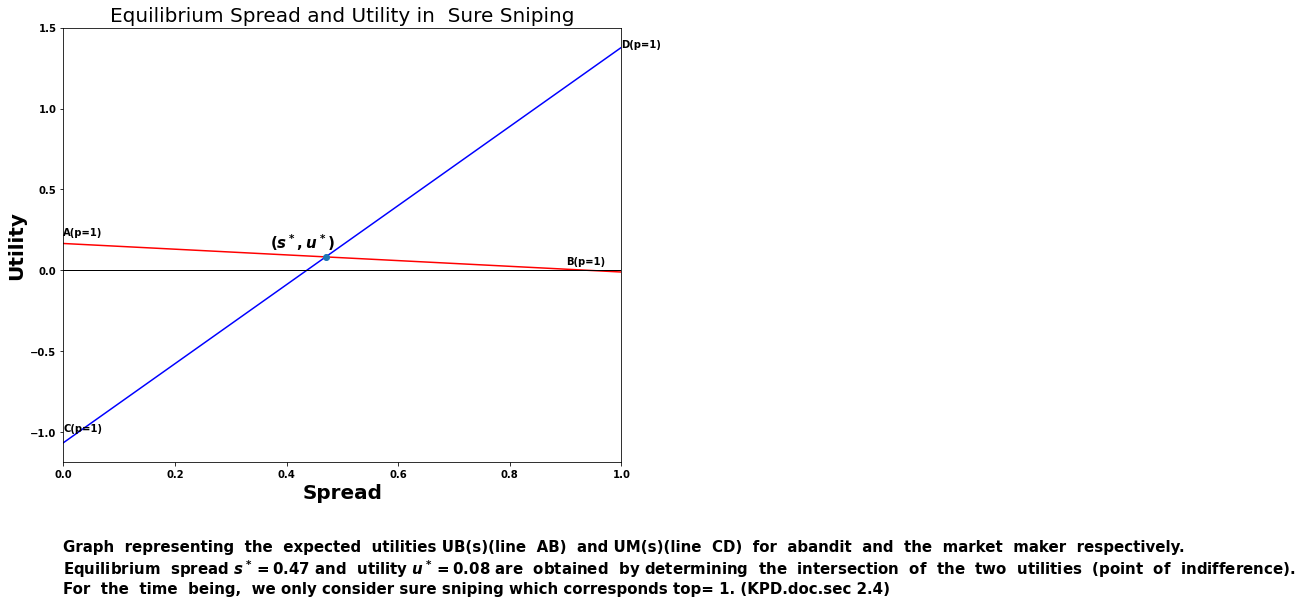

In [ ]:
# KPD.fig.2 representing equilibrium spread and utility in sure sniping

# Graph  representing expected  utilities:
# UB(s)(line  AB)  and UM(s)(line  CD)  for  abandit  and  the  market  maker  respectively.  
# Equilibrium  spread (s*) and  utility (u*) are obtained 
# by determining the intersection of the two utilities (point  of  indifference).   

A_numeric = A.subs(dict_numerical_vals)
B_numeric = B.subs(dict_numerical_vals)

C_numeric = C.subs(dict_numerical_vals)
D_numeric = D.subs(dict_numerical_vals)


plt.plot( [0, s_star_sure_sniping,1], [A_numeric,u_star_sure_sniping,B_numeric], 'r')
plt.plot( [0, s_star_sure_sniping,1],[C_numeric,u_star_sure_sniping,D_numeric], 'b')
plt.plot(s_star_sure_sniping, u_star_sure_sniping, 'o')

plt.axhline(linewidth=1, color='k')
plt.title("Equilibrium Spread and Utility in  Sure Sniping",fontsize=20)
plt.ylabel ("Utility",fontsize=20)
plt.xlabel("Spread",fontsize=20)

plt.text(s_star_sure_sniping-0.1, u_star_sure_sniping+.05, "$(s^*, u^*)$",fontsize=15)
plt.text(0,A_numeric +0.05, "A(p=1)")
plt.text(0.9, B_numeric+0.05,"B(p=1)")
plt.text(0,C_numeric+.02 +0.05, "C(p=1)")
plt.text(1, D_numeric,"D(p=1)")
plt.xlim(0,1);
caption = '''
Graph  representing  the  expected  utilities UB(s)(line  AB)  and UM(s)(line  CD)  for  abandit  and  the  market  maker  respectively.
Equilibrium  spread $s^* = ${} and  utility $u^*=${} are  obtained  by determining  the  intersection  of  the  two  utilities  (point  of  indifference).
For  the  time  being,  we only consider sure sniping which corresponds top= 1. (KPD.doc.sec 2.4) '''.format(round(s_star_sure_sniping,2),round(u_star_sure_sniping,2));

plt.text(0,-2,caption, fontsize = 15);


#8.2. Characterising the transitions in sniping behaviour :
Transition Thresholds (Risk Aversion factors) (KPD.section.4)


In [ ]:
# Transition Thresholds:

dict_numerical_vals[gamma] = gamma
#
print('============= Transition threshold (gamma_bar_K) =============')

# We compute gamma_K_cond in section.4, that is the result of du*/dp|(p=1) =0
gamma_K_cond_numeric = gamma_K_cond.subs(dict_numerical_vals)

# solving above equation gives the unique threshold we expect, that is the 
# zero-crossing and positive root >1. 

gamma_bar_K = solveset(gamma_K_cond_numeric,gamma)

list_roots = list(gamma_bar_K)
print('')
print('-------------- list of polynomial roots ----------------')
print(' polynomial roots= ', list_roots)
print('')

print('-------------- Positive root >1  ----------------')
gamma_bar_K =  list_roots[0]
print('gamma_bar_K =', gamma_bar_K)

print('')

print('============= Transition threshold (gamma_bar_L) =============')

#  Using eq. ???? in main text: 
Z = 1+mubar_val-beta_val*(1-mubar_val)
gamma_bar_L = 1+np.sqrt((1-mubar_val)*Z/(alphabar_val*thetabar_val))

print('gamma_bar_L = ', gamma_bar_L)



# The same procedure applies to the second threshold. 
# gamma_L_cond is du*/dp|(p=0) =0

gamma_L_cond = dN_dp_0 *Q_0 -  N_0 *dQ_dp_0

gamma_L_cond = gamma_L_cond.subs({q:gamma-1})

gamma_L_cond_numeric = gamma_L_cond.subs(dict_numerical_vals).cancel().collect(gamma)

# solving gamma_L_cond gives the unique threshold we expect, that is the 
# zero-crossing and positive root >1. 

gamma_bar_L = solveset(gamma_L_cond_numeric,gamma)
list_roots_t2 = list(gamma_bar_L)
print('')
print('--------------list of polynomial roots ----------------')
print(' polynomial roots= ', list_roots_t2)
print('')

print('-------------- positive root >1  ----------------')
gamma_bar_L =  list_roots_t2[2]
print('gamma_bar_L =', gamma_bar_L)

Z = 1+mubar_val-beta_val*(1-mubar_val)
print('Z= ', Z)
gamma_bar_L_quadraticroot = 1+np.sqrt((1-mubar_val)*Z/(alphabar_val*thetabar_val))

print('gamma_bar_L_quadraticroot = ', gamma_bar_L_quadraticroot)



============= Transition threshold (gamma_bar_K) =============

-------------- list of polynomial roots ----------------
 polynomial roots=  [2.60383621839367, -2.84114098309713 - 1.11564605438218*I, -2.84114098309713 + 1.11564605438218*I]

-------------- Positive root >1  ----------------
gamma_bar_K = 2.60383621839367

============= Transition threshold (gamma_bar_L) =============
gamma_bar_L =  7.831300510639732

--------------list of polynomial roots ----------------
 polynomial roots=  [-5.83130051063973, -5.00000000000000, 7.83130051063973]

-------------- positive root >1  ----------------
gamma_bar_L = 7.83130051063973
Z=  0.7105263157894737
gamma_bar_L_quadraticroot =  7.831300510639732


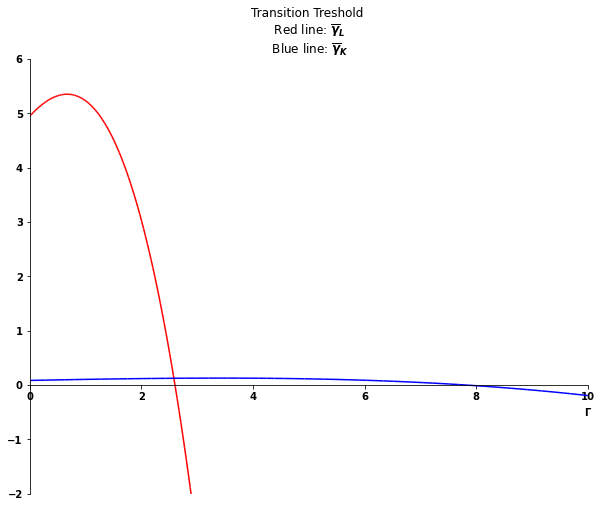


Probabilistic sniping is profitable for values of the risk aversion parameter gamma between 
the thresholds gamma_bar_K and gamma_bar_L that are the positive zero-crossing (exceeding 1) of cubic and quadratic equations.


In [ ]:
# plot the transition thresholds 
#--------

plt= plot(gamma_K_cond_numeric,(gamma, 0,10),line_color ='r',xlim=[0,10], ylim=[-2,6],show=False,\
          title = 'Transition Treshold \n Red line: $\overline{\gamma}_L$ \n Blue line: $\overline{\gamma}_K$ ', xlabel = '$\Gamma$',ylabel='',adaptive =False)
plt.extend(plot(gamma_L_cond_numeric,(gamma,0,10),line_color ='b',xlim=[0,10], ylim=[-.1,0.2],show=False));

plt.show()

caption = '''
Probabilistic sniping is profitable for values of the risk aversion parameter gamma between 
the thresholds gamma_bar_K and gamma_bar_L that are the positive zero-crossing (exceeding 1) of cubic and quadratic equations.'''
#--------
print(caption)


**8.2.1.Transition thresholds in different settings of important parameters (news ($\alpha$) and LT arrival ($\mu$))**





{alpha: alpha, mu: 0.5, delta: 0.5, H: 5, gamma: gamma, q: 0.5, beta: 0.4736842105263158, mubar: 0.125, thetabar: 0.11842105263157895, alphabar: alphabar, -mubar + 1: 0.875, 'h': (5*p + (-p + 1)**5 - 1)/(5*p), 'g': (5*p + (-p + 1)**5 - 1)/(20*p**2), p: 1, s: 0.469950293718934}


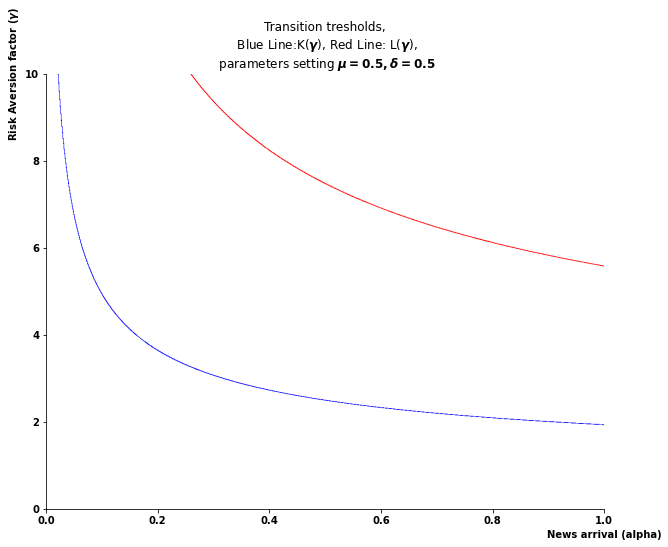

In [ ]:
# Adjust the dictionary and convert parameteres we need to symbol (In this case alpha, alphabar)
dict_adjust_alpha = copy.deepcopy(dict_numerical_vals)
dict_adjust_alpha[alpha] = alpha
dict_adjust_alpha[alphabar] = alphabar

dict_adjust_alpha[gamma] = gamma

print(dict_adjust_alpha)

# Recall gamma_K_cond and gamma_L_cond in section.6 and 7 (the result of du*/dp|(p=1,0) =0)
#-------
gamma_K_cond_numeric_expr = gamma_K_cond.subs(alphabar, alpha*delta/2).subs(dict_adjust_alpha).cancel()

gamma_L_cond_numeric_expr = gamma_L_cond.subs(alphabar, alpha*delta/2).subs(dict_adjust_alpha).cancel()
#-------

# plot polynomial_L 
sym_plot_GL= plotting.plot_implicit(gamma_L_cond_numeric_expr, (alpha,0,1 ),(gamma,0,10), line_color='r', show=False)

sym_plot= plotting.plot_implicit(gamma_K_cond_numeric_expr, (alpha,0,1 ),(gamma,0,10), xlabel = 'News arrival (alpha)', ylabel = 'Risk Aversion factor ($\gamma$)', show= False,
                                 title='Transition tresholds,\n Blue Line:K($\gamma$), Red Line: L($\gamma$),\n parameters setting $\mu = {}, \delta = {}$'.format(0.5, dict_adjust_alpha[delta]))
sym_plot.extend(sym_plot_GL)
sym_plot.show()

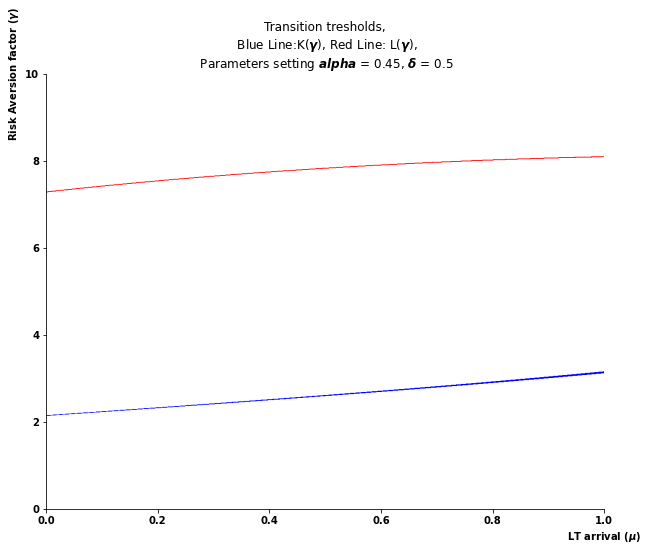

In [ ]:
# Adjust the dictionary and convert parameteres we need to symbol (mu and mubar)
dict_adjust_mu = copy.deepcopy(dict_numerical_vals)
# 
dict_adjust_mu[mu] = mu
dict_adjust_mu[mubar] = mubar
dict_adjust_mu[gamma] = gamma

# Recall thresholds
gamma_K_cond_numeric_expr_2 = gamma_K_cond.subs(mubar, mu*delta/2).subs(dict_adjust_mu).cancel()
gamma_L_cond_numeric_expr_2 = gamma_L_cond.subs(mubar, mu*delta/2).subs(dict_adjust_mu).cancel()
#-------

# plot polynomial_L 
sym_plot_GL_2= plotting.plot_implicit(gamma_L_cond_numeric_expr_2, (mu,0,1 ),(gamma,0,10), line_color='r', show=False)
sym_plot_2= plotting.plot_implicit(gamma_K_cond_numeric_expr_2, (mu,0,1 ),(gamma,0,10), xlabel = 'LT arrival ($\mu$)', ylabel = 'Risk Aversion factor ($\gamma$)', show= False,
                                 title='Transition tresholds,\n Blue Line:K($\gamma$), Red Line: L($\gamma$),\n Parameters setting $alpha$ = {}, $\delta$ = {}'.format(dict_numerical_vals[alpha], dict_numerical_vals[delta]))
sym_plot_2.extend(sym_plot_GL_2)
sym_plot_2.show()




# 8.3. Dependency of Risk Aversion and Equilibrium spread and utility 
 When is probabilistic sniping advantageous? (KPD.section.3.4)


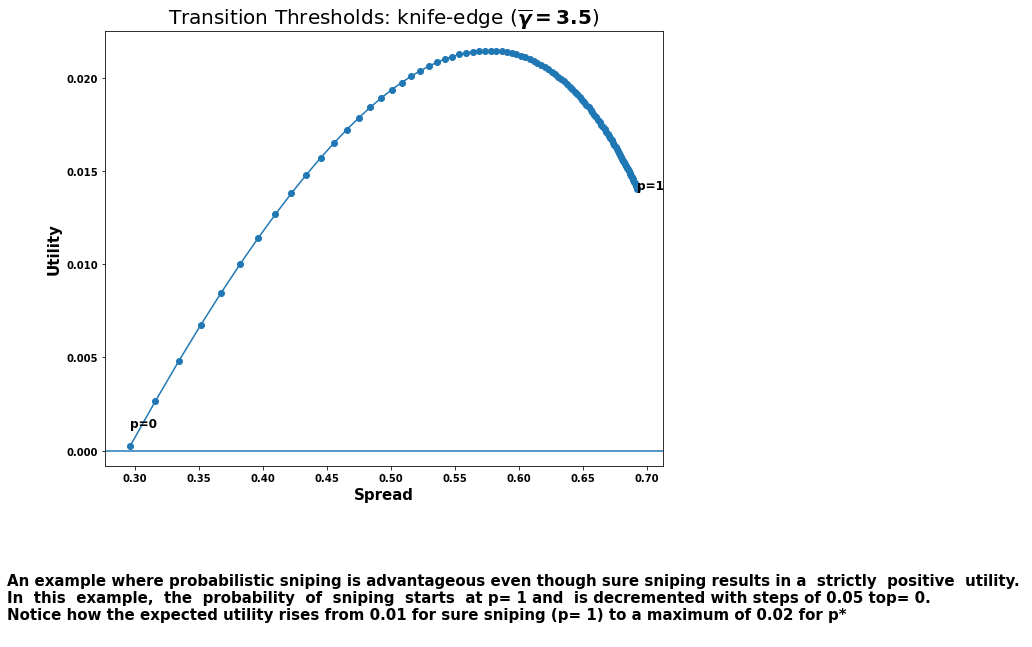

In [ ]:
# We update the dictionary values (p, gamma)
from sympy.abc import p

import matplotlib.pyplot as plt
dict_numerical_vals[p] = p
dict_numerical_vals[alphabar] = alphabar_val
dict_numerical_vals[mubar] = mubar_val

# Define a list of risk aversion factor (gamma)

gamma_0 = (1+ gamma_bar_K)/2
gamma_1 = gamma_bar_K
#gamma_2 = (gamma_bar_K + gamma_bar_L)/2
gamma_2 = 3.5
gamma_3= gamma_bar_L
Gamma = [ gamma_0, gamma_1,  gamma_2, gamma_3]

dict_numerical_vals[gamma] = Gamma[2]

# Compute spread an utility as a function of p , numerically.
# We expand q to make sure the value for gamma is updated.
u_star = u_star.subs({q:gamma-1})
u_star_p = u_star.subs(dict_numerical_vals).cancel()

s_star = s_star.subs({q:gamma-1})
s_star_p = s_star.subs(dict_numerical_vals).cancel()
# In order to plot the dependency of equilibrium utility spread on p
# We change sympy expressions to function

# Define a range of sniping probability
P = np.linspace(0.001,1,100)

u_star_P = lambdify(p, u_star_p)
u_star_P = u_star_P(P) # optimal utility as a function of p
#
s_star_P = lambdify(p, s_star_p)
s_star_P = s_star_P(P) # optimal spread as a function of p

plt.plot(s_star_P,u_star_P,'-o')
plt.title(r"Transition Thresholds: knife-edge ($\overline{\gamma} =%s $)"% Gamma[2], fontsize = 20)
plt.xlabel('Spread',fontsize=15)
plt.ylabel('Utility',fontsize=15)
plt.text(s_star_P[99],u_star_P[99],'p=1',fontsize=12)
plt.text(s_star_P[0],u_star_P[0]+0.001,'p=0',fontsize=12)
plt.axhline(0,0)
caption = '''
An example where probabilistic sniping is advantageous even though sure sniping results in a  strictly  positive  utility. 
In  this  example,  the  probability  of  sniping  starts  at p= 1 and  is decremented with steps of 0.05 top= 0.
Notice how the expected utility rises from {} for sure sniping (p= 1) to a maximum of 0.02 for p*
'''.format(round(u_star_P[99],2))
plt.text(0.2,-.01, caption, fontsize=15)
plt.show()


# 8.3.1. Example of transition thresholds from sure to probabilistic sniping and non sniping.


Examples for $\gamma$ [1.80191810919684, 2.60383621839367, 3.5, 7.83130051063973]
<function <lambda> at 0x7f56c1026b70>
<function <lambda> at 0x7f56c1026378>
<function <lambda> at 0x7f56cc403a60>
<function <lambda> at 0x7f56c10bda60>
Examples for dependency of equilibrium utility spread to thresholds (risk aversion factor) 


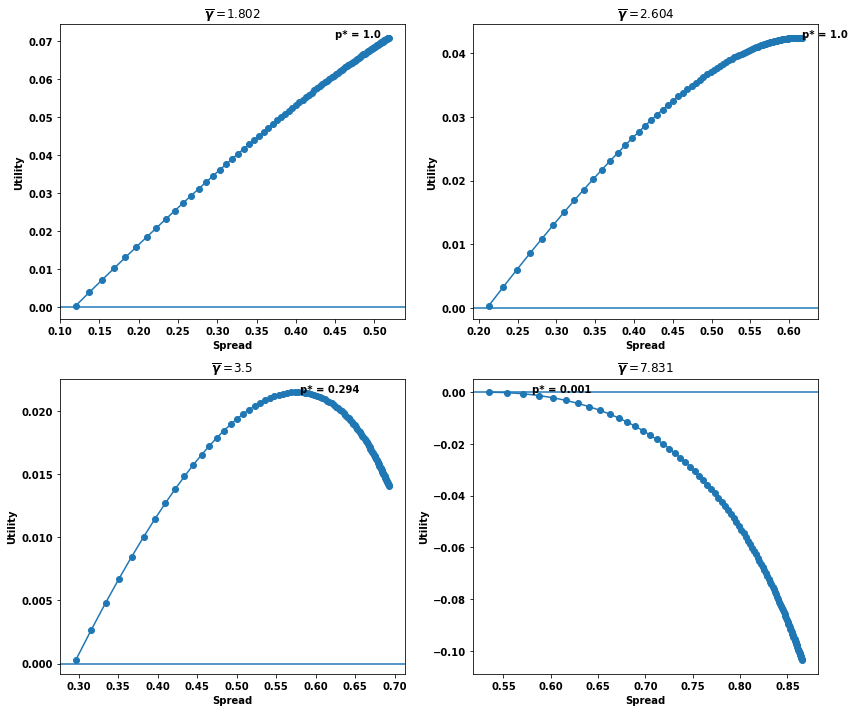

In [ ]:
# first we update dictionary of values with different examples of Risk aversion factor (gamma)
# Then we compute the Equilibrium spread and utility with respect to examples of gamma
# Finallt we can extract p* by finding corresponding p to maximum equilibrium utility  

# 1) Update the dictionary with different examples of gamma
print('Examples for $\gamma$', Gamma)

list_gamma_exmp=[];
S_star =[];
U_star = [];
for i in Gamma:
  '''
   by using examples in section 8.3
   we update the dictionary of values for each example
  '''
  dict_numerical_vals[gamma]= i;
  list_gamma_exmp.append(dict_merge(dict_numerical_vals));

  
# 2) Compute Equilibrium spread and uriliry for each example    
for j in list_gamma_exmp:
  '''
  Compute euilibrium spread and utility for each example
  '''
  u_star = ( A *D - B*C)/N
  u_star = u_star.subs({q:gamma-1});
  u_star_gamma = u_star.subs(j);
  U_star.append(u_star_gamma);

  s_star = (A - C)/ N
  s_star = s_star.subs({q:gamma-1});
  s_star_gamma = s_star.subs(j);
  S_star.append(s_star_gamma);

# 3) Define a range for sniping probability from zero (no-sniping) to 1 (sure sniping)
 
P = np.linspace(0.001,1,100)
U_total=[]; # To store optimal utilities 
for j in U_star:
     u_star_1 = lambdify(p, j);
     print(u_star_1);
     U_total.append(u_star_1(P));
S_total =[];
for ii in S_star:
    s_star_1 = lambdify(p,ii);
    S_total.append(s_star_1(P));

#------------------
# Optimal sniping probability is when utility has the highst value (for 4 examples)

u_max=[] # To store maximum u* 
Id =[] # corresponding index to find p*
for ii in U_total:
  i_max=max(ii);
  u_max.append(i_max);


for jj in u_max:
  idx = np.where(U_total == jj);
  Id.append(idx);
# print('Corresponding indices to find p* :')
# print(Id)
p_star_exp0 = P[Id[0][1]];
p_star_exp1 = P[Id[1][1]];
p_star_exp2 = P[Id[2][1]];
p_star_exp3 = P[Id[3][1]];

# as we selected gamma =3.5 for computations in this notebook,
# corresponding p_star is p_star_exp2  
p_star  = p_star_exp2 

print("Examples for dependency of equilibrium utility spread to thresholds (risk aversion factor) ")
fig, ax = plt.subplots(2,2, figsize=(12, 10));

ax[0,0].plot(S_total[0], U_total[0],'o-');
ax[0,0].set_title("$\overline{\gamma}$ =%s" % round(Gamma[0],3));

ax[0,0].text(0.45,u_max[0], "p* = %s" % p_star_exp0[0]);
#
ax[0,1].plot(S_total[1], U_total[1],'o-');
ax[0,1].set_title("$\overline{\gamma}$ =%s" % round(Gamma[1],3));

ax[0,1].text(max(S_total[1]),u_max[1], "p* = %s" % p_star_exp1[0]);
#
ax[1,0].plot(S_total[2], U_total[2],'o-');
ax[1,0].set_title("$\overline{\gamma}$ =%s" % round(Gamma[2],3));

ax[1,0].text(0.58,u_max[2], "p* = %s" % round(p_star_exp2[0],3));
#
ax[1,1].plot(S_total[3], U_total[3],'o-');
ax[1,1].set_title("$\overline{\gamma}$ =%s" % round(Gamma[3],3));

ax[1,1].text(0.58,u_max[3], "p* = %s" % round(p_star_exp3[0],3));

for ax in ax.flat:
    ax.set(xlabel='Spread', ylabel='Utility');
    ax.axhline(0,0)
fig.tight_layout()



#8.4 Expected Utility and probabilistic sniping:


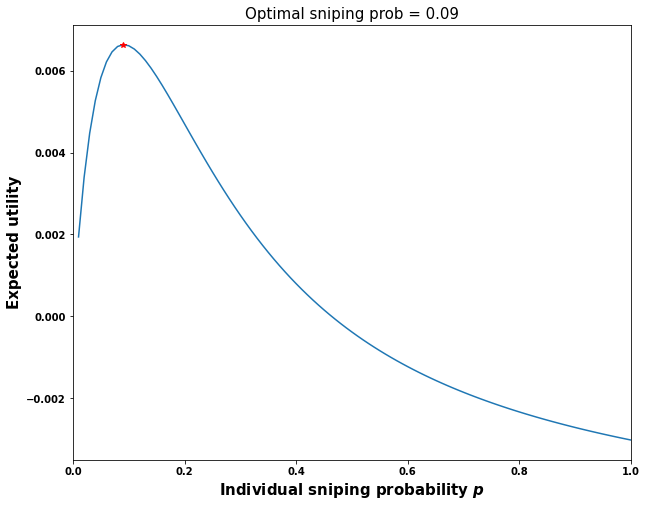

In [ ]:
dict= dict_subs_numerical_vals.copy()
dict[p] = p
dict[gamma] = 4 #(gamma_bar_K + gamma_bar_L)/2
dict['h'] = (H*p + (1 - p)**H - 1)/(H*p)
dict['g'] = (H*p + (1 - p)**H - 1)/(H*p)/((H-1)*p)

nr_agents = {H:10}
# sure
A_p_1 = A.subs(dict).subs(p,1).subs(nr_agents)
B_p_1  = B.subs(dict).subs(p,1).subs(nr_agents)
# B_p_1  = B.subs({p*g:1/H})

C_p_1 = C.subs(q, gamma-1).subs(dict).subs(p,1).subs(nr_agents)
D_p_1 = D.subs(q, gamma-1).subs(dict).subs(p,1).subs(nr_agents)
#------------------
# compute u_star (p)
u_star_pp = u_star.subs(dict).subs(nr_agents)

#------------------
# Compute max to determine p_star, s_star, u_star

uu=[] # To store maximum u*

from sympy.abc import p

P = np.linspace(0.01,1, 100)
for i in P:
    u_star_11 = u_star_pp.subs(p,i)
    uu.append(u_star_11)

import operator
index, value = max(enumerate(uu), key=operator.itemgetter(1))

p_star_example = P[index] 

u_star_pp = u_star_pp.subs(p, p_star_example)

plt.plot(P, uu)
plt.plot(p_star_example,u_star_pp, 'r*')
plt.xlabel('Individual sniping probability $p$', fontsize = 15)
plt.ylabel('Expected utility', fontsize = 15)
plt.title('Optimal sniping prob = %s' % round(p_star_example,2), fontsize = 15)
plt.xlim(0,1);


# 8.4.1. Optimal utility & spread $u^*(p^*) , s^*(p^*)$

In [ ]:
# update dictionary by p_star 

dict[p] = p_star

# Collective probabilistic sniping

A_p_star = A.subs(dict).subs(nr_agents)
B_p_star  = B.subs(dict).subs(nr_agents)

C_p_star = C.subs(q, gamma-1).subs(dict).subs(nr_agents)
D_p_star = D.subs(q, gamma-1).subs(dict).subs(nr_agents)

#------------------
u_star_pp = u_star.subs(dict).subs(nr_agents)

s_star_pp = s_star.subs(dict).subs(nr_agents)

#------------------
print('s*(p*)', s_star_pp)
print('u*(p*)', u_star_pp)

s*(p*) 0.691286650479249
u*(p*) 0.00259632036358265


#8.5. Quantification of deviation: 
In this section, we compute expected utility for each agent based on conditional sniping probability for trustworthy agents


In [ ]:
# This function computes utility for trustworthy agent as MM and Bandit

def compute_utility_trustworthy(Hd,Ht,alpha,mu,delta,gamma,H,p,s_star):
  
    # initial parametres 
    beta = alpha/(alpha + mu)
    alphabar  = alpha  * delta /2
    mubar = mu * delta/2
    q = gamma -1
    thetabar = 2*alphabar*mubar/(alphabar +mubar)
    m = 1- mubar

    def compute_htm_gtb(Ht,Hd,p):
      '''
      Compute ht_m (trustworthy agent as Market maker)
      and g_tb (trustworthy agent as bandit)

      '''
      H = Hd+Ht
      Nt = np.random.binomial(Ht-1, p)
      h_tm = np.mean((Hd+Nt) / (1+Hd+Nt))
      Nt_1 = np.random.binomial(Ht-2, p)
      Nt_2 = np.random.binomial(Ht-1, p)
      g_tb = np.mean(1/(2+Hd+Nt_1))*((Ht-1)/(H-1)) + np.mean(1/(1+Hd+Nt_2))*(Hd/(H-1))
      
      # Alternative computation for g_tb
      Nt = np.random.binomial(Ht-1,p)
      g_tb_2 = (1/(H-1))* np.mean(Hd*(1./(1+Nt+Hd)) + Nt/(1+Nt+Hd) + (Ht-1-Nt)/(2+Nt+Hd) )

      return h_tm, g_tb, g_tb_2
      
    h_tm = compute_htm_gtb(Ht,Hd,p)[0]
    g_tb = compute_htm_gtb(Ht,Hd,p)[1]
    g_tb_2 = compute_htm_gtb(Ht,Hd,p)[2] 


    # Compute endpoints for trustworthy bandit
    A_tb = m*beta*p*g_tb;
    B_tb = -alphabar*q*beta*p*g_tb;

    u_tb = A_tb*(1-s_star) + B_tb*s_star; # trustworthy agent as bandit   # F1  in paper fig

    # Compute endpoints for trustworthy MM
    C_tm = -(q*thetabar + beta*(m*gamma-mubar*q)*h_tm)
    D_tm = (1+mubar) - beta*(m + alphabar*q*h_tm)

    u_tm = C_tm*(1-s_star) + D_tm*s_star # trustworthy agent as MM  # F2 in paper fig

    # Weighted utility for trustworthy agents
    u_t_actual = ((H-1)/H)*u_tb + (1/H)*u_tm
    return A_tb, B_tb, C_tm, D_tm, u_tb,u_tm,u_t_actual,compute_htm_gtb(**dict_agents) 



**8.5.1 Extract the expected utilites and probability for trustworthy agents**

In [ ]:
#@title
# initial params for the case of deviation 
dict_deviation = {'alpha': alpha_val, 'mu' : mu_val, 'delta' :delta_val, 'gamma' :Gamma[2]}

dict_deviation['H'] = 5 # Total nr of agents
dict_deviation['Hd'] = 1
dict_deviation['Ht'] = 4

dict_deviation['p'] = p_star
dict_deviation['s_star'] = s_star_pp

dict_agents = {'Ht':8, 'Hd': 2, 'p':p_star}
print("--------- initial params for the case of deviation ---------")
print(dict_deviation)

# print the result (utility end points and probability)
outcome_utility = compute_utility_trustworthy(**dict_deviation)

A_tb = outcome_utility[0]
B_tb = outcome_utility[1]
C_tm = outcome_utility[2]
D_tm = outcome_utility[3]

u_tb = outcome_utility[4]
u_tm = outcome_utility[5]

u_t_actual = outcome_utility[6]

outcome_probability = outcome_utility[7]

print(outcome_utility)


--------- initial params for the case of deviation ---------
{'alpha': 0.45, 'mu': 0.5, 'delta': 0.5, 'gamma': 3.5, 'H': 5, 'Hd': 1, 'Ht': 4, 'p': array([0.294]), 's_star': 0.691286650479249}
(array([0.033]), array([-0.011]), -0.9473684210526316, 0.6439144736842105, array([0.00289551774716384], dtype=object), 0.152664201214923, array([0.0328492544407157], dtype=object), (0.8, 0.15555555555555556, 0.15608465608465608))


**8.5.1.1 Plot expected utilities for trustworthy agents in equilibrium point** 

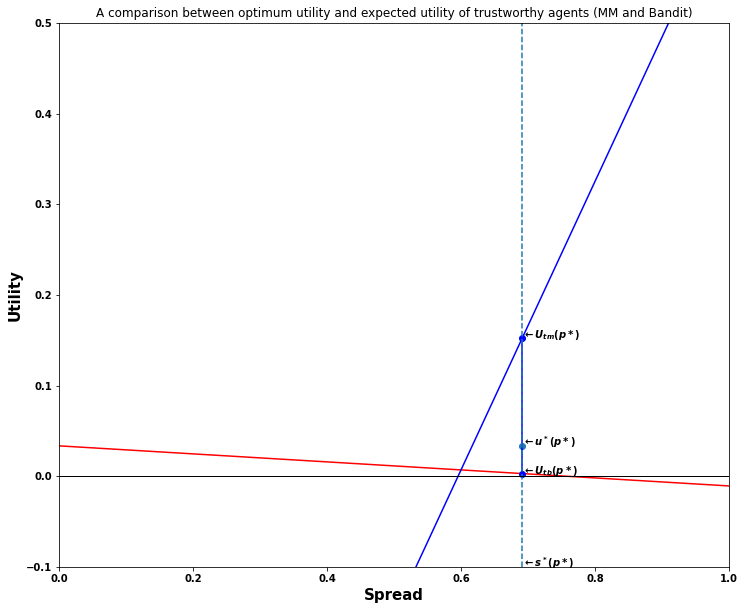

In [ ]:

fig_1 =plt.figure(1, figsize=(12, 10))

plt.plot([0,1], [A_tb, B_tb], 'r') # end points Bandit utility
plt.plot([0,1],[C_tm,D_tm], 'b')   # End points MM utility

plt.plot(s_star_pp , u_t_actual,'o') # optimum spread and weighted utility for trustworthy agent
plt.plot(s_star_pp, u_star_pp, '*')  # optimum spread and utility 

plt.plot([s_star_pp, s_star_pp], [u_tb,u_tm], 'bo-') # Bandit & MM utility

# Add description to each point
plt.text(s_star_pp, u_tb, '$\leftarrow U_{tb}(p*)$')
plt.text(s_star_pp, u_tm, '$\leftarrow U_{tm}(p*)$')
plt.text(s_star_pp, u_t_actual, '$\leftarrow u^*(p*)$')

plt.text(s_star_pp, -.1, '$\leftarrow s^*(p*)$')
plt.axvline(s_star_pp,linestyle='--')
plt.axhline(linewidth=1, color='k')
plt.xlabel('Spread', fontsize = 15)
plt.ylabel('Utility', fontsize = 15)
# To zoom in the plot for clearer vision
plt.xlim(0,1);
plt.ylim(-.1,.5);
plt.title('A comparison between optimum utility and expected utility of trustworthy agents (MM and Bandit)');


**8.5.1.2 Plot Utilities for Deceptive agent in equilibrium point** 

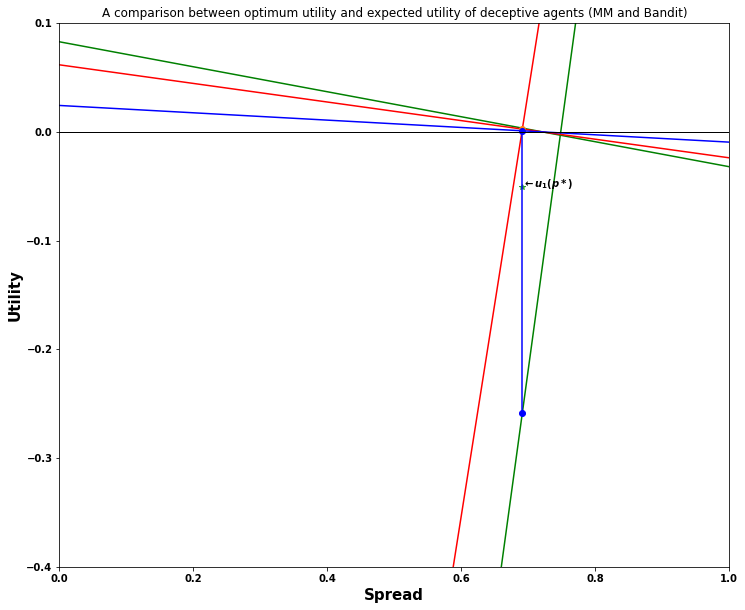

In [ ]:
#  Utilities for a single honest sniper who is competing with H-1 
#  deceptive agents that snipe for sure

# call A, B , g = 1/H
A_1 = m*beta*p/H;
B_1 = -alphabar*q*beta*p/H;

A_1 = A_1.subs(dict).subs(nr_agents)
B_1 = B_1.subs(q, gamma-1).subs(dict).subs(nr_agents)


# Utility of the honest agent as bandit
u_1_as_bandit = A_1*(1-s_star_pp) + B_1*s_star_pp;  
u_1_as_bandit = u_1_as_bandit.subs(dict)
# Utility of the honest agent as market maker 
u_1_as_marketmaker = C_p_1*(1-s_star_pp) + D_p_1*s_star_pp   
u_1_as_marketmaker = u_1_as_marketmaker.subs(dict)
# Expected utility of honest agent (weighted for role as bandit or market
# maker): 

u_1_actual = ((H-1)/H)*u_1_as_bandit + (1/H)*u_1_as_marketmaker
u_1_actual = u_1_actual.subs(dict)

#--------------
import matplotlib.pyplot as plt

fig_1 =plt.figure(1, figsize=(12, 10))

plt.plot([0,1], [A_p_1, B_p_1], 'g') # Bandit utility (p=1)
plt.plot([0,1],[C_p_1,D_p_1], 'g')   # MM utility (p=1)

plt.plot([0,1], [A_p_star, B_p_star], 'r')  # Bandit utility (p=p*)
plt.plot([0,1],[C_p_star ,D_p_star], 'r')   # MM utility (p=p*)

plt.plot([0,1], [A_1,B_1], 'b') # bandit utility when(g =1/H)

plt.plot([s_star_pp, s_star_pp], [0 , u_star_pp],':')
plt.plot(s_star_pp, u_star_pp, marker = 'o')
plt.plot(s_star_pp, u_1_actual, marker = '*')
plt.text(s_star_pp, u_1_actual, '$\leftarrow u_1(p*)$')

plt.plot([s_star_pp, s_star_pp], [u_1_as_bandit,u_1_as_marketmaker], 'bo-')

plt.axhline(linewidth=1, color='k')
plt.xlabel('Spread', fontsize = 15)
plt.ylabel('Utility', fontsize = 15)
plt.title('A comparison between optimum utility and expected utility of deceptive agents (MM and Bandit)');
# To zoom in the plot for clearer vision
plt.xlim(0,1)
plt.ylim(-.4,0.1);

